In [1]:
import os
import sys

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from weaviate_rag.rag_system import GraphRAGSystem
import ollama
from ragas import evaluate
from ragas.metrics import Faithfulness, AnswerRelevancy, ContextRecall
import re
from ragas import EvaluationDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Device set to use mps:0


In [2]:
# Load your JSON data
# with open('/Users/alexlecu/PycharmProjects/LLMKGraph/backend/evaluation/data/grok_evaluation_dataset_mini/True_or_False_questions_mini.json', 'r') as f:
with open('/Users/alexlecu/PycharmProjects/LLMKGraph/backend/evaluation/data/grok_evaluation_datasets/1_Hop_MCQ_Questions.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame for analysis
df = pd.DataFrame(data)
df = df[['question', 'answer']]

# Add columns for evaluation
df['contexts'] = None  # Will be filled with retrieved passages
df['with_context_answer'] = None  # Will be filled with RAG responses
df['without_context_answer'] = None  # Will be filled with model-only responses

In [3]:
def generate_answer_with_context(question, context, model="llama3.2"):
    """Generate answer using the model with context - simplified prompt"""
    # More direct prompt focused on true/false determination
    system_prompt = f"""
    Given the following medical information, select the correct answer from the options provided (A, B, C, D).
    
    INFORMATION:
    {context}
    
    IMPORTANT: Respond with ONLY the letter of the correct option (e.g., "A", "B", "C", or "D").
    """
   
    response = ollama.chat(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question}
        ],
        stream=False
    )
    return response['message']['content']

In [4]:
def generate_answer_without_context(question, model="llama3.2"):
    """Generate answer using the model without context"""
    system_prompt = """
    Select the correct answer from the options provided (A, B, C, D).
    
    IMPORTANT: Respond with ONLY the letter of the correct option (e.g., "A", "B", "C", or "D").
    """
    
    response = ollama.chat(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question}
        ],
        stream=False
    )
    return response['message']['content']

In [5]:
def remove_think_tags(response):
    """Remove any thinking tags from the response"""
    if response is None:
        return ""
    cleaned_content = re.sub(r'<think>.*?</think>', '', response, flags=re.DOTALL)
    return cleaned_content

In [6]:
def parse_true_false(response):
    """Parse the response to extract True/False answer"""
    if response is None:
        return None
        
    # Clean up response
    response = response.strip().lower()
    
    # Check for True/False keywords
    if "true" in response:
        return True
    elif "false" in response:
        return False
    else:
        print(f"Warning: Could not parse true/false from: '{response}'")
        return None

In [7]:
# Loop through questions and generate answers with context
contexts = []
with_context_responses = []

print("Processing questions with context...")
for index, row in df.iterrows():
    # Retrieve context
    analyzer = GraphRAGSystem(row["question"])
    context = analyzer.analyze()

    contexts.append(context)
    
    # Generate answer with context
    response = generate_answer_with_context(row["question"], context, "llama3.2")
    response = remove_think_tags(response)
    with_context_responses.append(response)
    
    print(f"Question {index+1}: {row['question']}")
    print(f"Context: {context[0][:100]}...")
    print(f"Response: {response}\n")

# Add to dataframe
df['contexts'] = contexts
df['with_context_answer'] = with_context_responses

Processing questions with context...
Question 1: Which retinal layer is most affected by AMD? a) Ganglion cell layer b) Macula c) Outer plexiform layer d) Choroid
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51087), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 2: What is the primary visual symptom of wet AMD? a) Peripheral vision loss b) Sudden central vision distortion c) Color blindness d) Night blindness
Context: T...
Response: b) Sudden central vision distortion



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51135), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 3: Which condition is dry AMD most likely to progress to? a) Glaucoma b) Geographic atrophy c) Cataracts d) Retinal detachment
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51193), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 4: What is a key environmental risk factor for AMD? a) High altitude b) Smoking c) Cold weather d) Noise exposure
Context: T...
Response: b) Smoking



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51219), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 5: Which type of AMD typically progresses more rapidly? a) Dry AMD b) Wet AMD c) Early AMD d) Intermediate AMD
Context: T...
Response: d) Intermediate AMD



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51255), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 6: What is the current status of a cure for advanced AMD? a) Fully curable b) Partially curable c) No cure exists d) Cure in trials
Context: T...
Response: c) No cure exists



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51298), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 7: Which therapy is commonly used for wet AMD? a) Anti-VEGF injections b) Topical steroids c) Acupuncture d) Hearing aids
Context: T...
Response: A
The best answer is A.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51372), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 8: Which vision type is least affected by AMD? a) Central vision b) Peripheral vision c) Depth perception d) Color vision
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51401), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 9: What genetic factor increases AMD risk? a) Family history b) Hair color c) Blood type d) Height
Context: T...
Response: A
The best answer is A.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51450), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 10: Which diagnostic method is ineffective for AMD? a) OCT b) Amsler grid c) Blood pressure test d) Fundus photography
Context: T...
Response: d



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51524), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 11: What tool is used to monitor AMD-related distortion? a) Stethoscope b) Amsler grid c) Thermometer d) ECG
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51548), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 12: Which AMD type is more prevalent? a) Wet AMD b) Dry AMD c) Both equally d) Neither
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51571), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 13: What is the effect of sunglasses on AMD prevention? a) Fully prevents b) Reduces risk c) No effect d) Increases risk
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51599), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 14: Which systemic condition heightens AMD risk? a) Asthma b) Diabetes c) Arthritis d) Migraines
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51628), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 15: What is the primary treatment focus for dry AMD? a) Surgery b) Slowing progression c) Reversing damage d) Pain relief
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51683), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 16: What retinal feature is characteristic of dry AMD? a) Fluid leakage b) Drusen deposits c) Blood vessel rupture d) Corneal opacity
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51720), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 17: At what age does AMD risk significantly increase? a) 30 b) 40 c) 50 d) 60
Context: T...
Response: C



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51744), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 18: Which symptom is most associated with wet AMD? a) Gradual peripheral loss b) Sudden central blur c) Eye redness d) Floaters
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51774), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 19: Is AMD transmissible between people? a) Yes, highly b) Yes, mildly c) No d) Only genetically
Context: T...
Response: c) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51799), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 20: Which lifestyle factor exacerbates AMD? a) Regular exercise b) Obesity c) Adequate sleep d) Hydration
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51824), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 21: Can surgery fully reverse AMD damage? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51863), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 22: What visual ability does AMD often impair? a) Color perception b) Hearing acuity c) Taste sensitivity d) Peripheral motion
Context: T...
Response: D



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51888), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 23: Which is not a cause of AMD? a) Aging b) Genetics c) Screen time d) UV exposure
Context: T...
Response: A
Explanation: While all options except "A" are causes or risk factors for Age-Related Macular Degeneration (AMD), option A, "Aging", is not the correct answer to this question as it has already been identified that aging is indeed a cause of AMD.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51911), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 24: What imaging technique is critical for AMD diagnosis? a) X-ray b) MRI c) OCT d) Ultrasound
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51941), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 25: What does wet AMD typically involve? a) Drusen reduction b) Fluid leakage c) Lens thickening d) Iris damage
Context: S...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51963), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 26: Which gender has a slightly higher AMD prevalence? a) Men b) Women c) Equal d) Unknown
Context: T...
Response: C



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51983), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 27: Are over-the-counter eye drops effective for AMD? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52006), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 28: Which cardiovascular condition increases AMD risk? a) Low blood pressure b) Hypertension c) Arrhythmia d) Anemia
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52035), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 29: What metabolic factor is linked to AMD? a) High cholesterol b) Low sodium c) High potassium d) Low glucose
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52070), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 30: Can dietary fish oil alone halt AMD? a) Yes b) No c) Sometimes d) Only with supplements
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52096), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 31: Which eye structure remains unaffected by AMD? a) Macula b) Optic nerve c) Retinal pigment epithelium d) Choroid
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52121), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 32: What therapy targets blood vessels in wet AMD? a) Chemotherapy b) Photodynamic therapy c) Radiation d) Massage
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52161), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 33: Does AMD increase physical risks in the elderly? a) Falls b) Hearing loss c) Muscle weakness d) Appetite loss
Context: T...
Response: The correct answer is: All of the above.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52197), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 34: Is AMD typically unilateral at onset? a) Yes b) No c) Always d) Rarely
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52224), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 35: What supplement regimen slows dry AMD? a) AREDS b) Multivitamins c) Calcium pills d) Iron tablets
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52248), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 36: Which ethnicity has the highest AMD incidence? a) African Americans b) Caucasians c) Asians d) Hispanics
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52264), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 37: Does wet AMD inevitably cause total blindness? a) Yes b) No c) Often d) Rarely
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52288), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 38: What visual distortion is typical of AMD? a) Double vision b) Wavy lines c) Flashing lights d) Tunnel vision
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52314), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 39: Is AMD caused by infectious agents? a) Yes b) No c) Sometimes d) Unknown
Context: S...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52337), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 40: Which functional ability does AMD impair? a) Depth perception b) Hearing sensitivity c) Olfactory detection d) Tactile response
Context: T...
Response: The correct answer is: None of the options are correct.

However, according to the information provided, we can infer that AMD impairs:

* Visual abilities
	+ Reading ability
	+ Driving ability
	+ General vision loss
	+ Spatial perception mobility
	+ Retinal sensitivity
	+ Central vision
	+ Other visual impairments

The options do not mention any of these visual impairments.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52365), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 41: Can AMD occur in young children? a) Yes b) No c) Rarely d) Only genetically
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52401), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 42: Does AMD necessitate visual aids? a) Yes b) No c) Sometimes d) Never
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52426), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 43: What environmental exposure is linked to AMD? a) Noise pollution b) UV light c) Air humidity d) Temperature extremes
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52440), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 44: Can exercise alone reverse AMD? a) Yes b) No c) Partially d) Only early stages
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52465), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 45: Which vision type is least impacted by AMD? a) Night vision b) Peripheral vision c) Central vision d) Contrast sensitivity
Context: T...
Response: d) Contrast sensitivity



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52492), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 46: What exam detects AMD? a) Blood draw b) Dilated eye exam c) Hearing test d) Skin biopsy
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52532), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 47: Is dim light reading a cause of AMD? a) Yes b) No c) Sometimes d) Unknown
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52556), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 48: Which daily task does AMD most impair? a) Face recognition b) Hearing conversations c) Smelling food d) Tasting flavors
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52579), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 49: Are antibiotics effective against AMD? a) Yes b) No c) Sometimes d) Only wet AMD
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52599), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 50: What demographic factor most influences AMD? a) Age b) Height c) Weight d) Hair color
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52624), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 51: Which retinal change is specific to wet AMD? a) Drusen increase b) Choroidal neovascularization c) Optic disc swelling d) Lens opacity
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52644), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 52: What is the effect of avoiding sunlight on AMD? a) Prevents completely b) Reduces risk c) No impact d) Worsens condition
Context: T...
Response: B.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52668), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 53: Which nutrient is not part of AREDS? a) Vitamin C b) Vitamin E c) Vitamin D d) Zinc
Context: T...
Response: c)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52704), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 54: What diagnostic sign does fluorescein angiography reveal in wet AMD? a) Drusen size b) Fluid leakage c) Lens clarity d) Corneal thickness
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52726), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 55: Which region has higher AMD prevalence? a) Developing countries b) Developed countries c) Tropical areas d) Polar regions
Context: T...
Response: C



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52756), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 56: Can wet AMD be fully reversed? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: d) Only early stages



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52780), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 57: What retinal structure is central to AMD pathology? a) Optic disc b) Macula c) Fovea d) Peripheral retina
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52803), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 58: Is poor hygiene a cause of AMD? a) Yes b) No c) Sometimes d) Unknown
Context: S...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52825), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 59: What assistive device helps AMD patients? a) Hearing aids b) Low vision aids c) Wheelchairs d) Inhalers
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52850), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 60: Which daily activity is most affected by AMD? a) Driving b) Tasting food c) Hearing music d) Smelling flowers
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52870), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 61: Does alcohol consumption directly cause AMD? a) Yes b) No c) Sometimes d) Only heavy use
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52892), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 62: What hereditary factor contributes to AMD? a) Eye color b) Genetic predisposition c) Skin tone d) Hair texture
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52916), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 63: Which retinal event occurs in wet AMD? a) Drusen dissolution b) Subretinal hemorrhage c) Optic nerve atrophy d) Lens detachment
Context: T...
Response: The correct answer is: B.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52941), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 64: Is staring at bright lights a direct cause of AMD? a) Yes b) No c) Sometimes d) Unknown
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52965), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 65: What screening method identifies AMD early? a) Blood test b) Eye exam c) Hearing test d) Skin scan
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52992), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 66: Does AMD cause floaters as a primary symptom? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53015), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 67: Which eye trait may elevate AMD risk? a) Dark eyes b) Light eyes c) Myopia d) Astigmatism
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53041), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 68: Can vitamin C alone cure AMD? a) Yes b) No c) Sometimes d) Only with zinc
Context: V...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53081), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 69: What visual defect does AMD often produce? a) Peripheral tunnel b) Central blind spots c) Flashing lights d) Double images
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53104), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 70: Is excessive sugar intake a direct AMD cause? a) Yes b) No c) Sometimes d) Unknown
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53134), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 71: What lifestyle change reduces AMD risk? a) More screen time b) Smoking cessation c) Less exercise d) High-fat diet
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53152), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 72: Does AMD exclusively impair night vision? a) Yes b) No c) Sometimes d) Only wet AMD
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53188), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 73: What retinal scan detects AMD? a) CT scan b) Retina scan c) PET scan d) MRI
Context: T...
Response: d



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53216), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 74: Can diet alone manage wet AMD? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53238), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 75: Which adaptation does AMD affect? a) Low light vision b) Hearing acuity c) Taste sensitivity d) Balance control
Context: T...
Response: A


Explanation: The correct answer is A, because the primary effect of AMD (Age-related Macular Degeneration) on vision loss is low light vision.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53259), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 76: Is lack of sleep a primary AMD cause? a) Yes b) No c) Sometimes d) Unknown
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53305), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 77: What routine check monitors AMD? a) Blood test b) Eye checkup c) Hearing exam d) Skin test
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53331), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 78: Does dry AMD cause retinal bleeding? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: c) Sometimes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53357), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 79: Which group has lower AMD rates? a) Caucasians b) African Americans c) Asians d) Europeans
Context: T...
Response: a



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53381), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 80: Can AMD cause hallucinations in late stages? a) Yes b) No c) Rarely d) Only wet AMD
Context: S...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53400), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 81: Is AMD exclusive to those over 80? a) Yes b) No c) Usually d) Rarely
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53424), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 82: What cellular process is linked to AMD? a) Oxidative stress b) Bone growth c) Muscle repair d) Skin regeneration
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53452), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 83: Is acupuncture a standard AMD treatment? a) Yes b) No c) Sometimes d) Only experimental
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53477), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 84: Which mental health issue may AMD increase? a) Depression b) Anxiety c) Memory loss d) All of the above
Context: T...
Response: d) All of the above



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53496), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 85: Do contact lenses cause AMD? a) Yes b) No c) Sometimes d) Only long-term use
Context: S...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53527), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 86: What photographic method aids AMD diagnosis? a) Fundus photography b) X-ray imaging c) Thermal imaging d) Ultrasound
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53552), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 87: Does wet AMD cause retinal scarring? a) Yes b) No c) Rarely d) Only early stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53576), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 88: Is vitamin D deficiency a direct AMD cause? a) Yes b) No c) Sometimes d) Unknown
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53599), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 89: Which spatial ability does AMD affect? a) Distance judgment b) Sound localization c) Taste distinction d) Smell detection
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53619), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 90: Does dry AMD always become wet AMD? a) Yes b) No c) Often d) Rarely
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53641), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 91: What is the estimated U.S. AMD case count? a) 1 million b) 5 million c) 11 million d) 20 million
Context: T...
Response: c) 11 million



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53667), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 92: Can avoiding all fats prevent wet AMD? a) Yes b) No c) Sometimes d) Only with diet
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53682), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 93: Which retinal feature is most indicative of early dry AMD? a) Fluid leakage b) Drusen deposits c) Retinal tears d) Optic disc swelling
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53705), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 94: What is a hallmark symptom of wet AMD? a) Gradual peripheral loss b) Wavy central vision c) Improved contrast d) Eye redness
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53725), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 95: Which stage of dry AMD precedes geographic atrophy? a) Early b) Intermediate c) Advanced d) Initial
Context: T...
Response: A
The information provided states that early/intermediate stages of AMD precede geographic atrophy, which is a more severe stage.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53765), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 96: What habit significantly increases AMD risk? a) Drinking coffee b) Smoking c) Walking daily d) Reading books
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53790), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 97: Which form of AMD is characterized by neovascularization? a) Dry AMD b) Wet AMD c) Early AMD d) Late AMD
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53816), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 98: Is there a definitive cure for intermediate AMD? a) Yes b) No c) In development d) Only for wet AMD
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53856), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 99: What injection targets wet AMD’s blood vessels? a) Insulin b) Anti-VEGF c) Steroids d) Antibiotics
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53883), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 100: Which vision aspect is preserved longest in AMD? a) Central acuity b) Peripheral vision c) Color distinction d) Depth perception
Context: A...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53909), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 101: What hereditary trait is linked to AMD? a) Family history b) Eye shape c) Hair length d) Skin color
Context: T...
Response: A
The best answer is A.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53939), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 102: Which test is irrelevant for AMD diagnosis? a) OCT b) Skin biopsy c) Amsler grid d) Fluorescein angiography
Context: T...
Response: c) Amsler grid



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53957), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 103: What home tool monitors AMD progression? a) Thermometer b) Amsler grid c) Blood pressure cuff d) Pulse oximeter
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53980), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 104: Which AMD type affects the majority of patients? a) Wet AMD b) Dry AMD c) Mixed AMD d) Neither
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54001), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 105: Can UV-blocking sunglasses eliminate AMD risk? a) Yes b) No c) Partially d) Only with diet
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54032), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 106: Which chronic illness is associated with higher AMD risk? a) Diabetes b) Allergies c) Bronchitis d) Osteoporosis
Context: T...
Response: a) Diabetes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54065), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 107: What is the main goal of dry AMD management? a) Cure b) Slow progression c) Reverse vision loss d) Reduce pain
Context: T...
Response: c) Reverse vision loss



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54097), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 108: What accumulates in the retina in dry AMD? a) Blood clots b) Drusen c) Tears d) Calcium deposits
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54127), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 109: What age group is most susceptible to AMD onset? a) 20-30 b) 30-40 c) 50-60 d) 60+
Context: T...
Response: c) 50-60



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54153), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 110: Which event is typical of wet AMD onset? a) Gradual drusen growth b) Sudden vision loss c) Peripheral blur d) Eye irritation
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54171), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 111: Can AMD spread through contact? a) Yes b) No c) Rarely d) Only genetically
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54202), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 112: Which metabolic state increases AMD likelihood? a) Obesity b) Low BMI c) High hydration d) Low cholesterol
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54228), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 113: Is surgical intervention a cure for AMD? a) Yes b) No c) Partially d) Only wet AMD
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54249), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 114: What visual function does AMD often alter? a) Color perception b) Auditory perception c) Taste sensitivity d) Peripheral speed
Context: T...
Response: d)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54275), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 115: Does excessive computer use directly cause AMD? a) Yes b) No c) Sometimes d) Only prolonged use
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54299), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 116: Which imaging method is essential for AMD evaluation? a) OCT b) CT scan c) MRI d) X-ray
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54321), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 117: What does wet AMD frequently cause in the retina? a) Drusen shrinkage b) Subretinal fluid c) Lens clouding d) Optic nerve swelling
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54342), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 118: Which demographic shows a slight AMD prevalence edge? a) Men b) Women c) No difference d) Children
Context: T...
Response: c) No difference



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54373), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 119: Are OTC eye drops a standard AMD treatment? a) Yes b) No c) Sometimes d) Only for dry AMD
Context: S...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54388), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 120: Which vascular condition is a known AMD risk factor? a) Hypotension b) Hypertension c) Varicose veins d) Anemia
Context: T...
Response: The correct answer is B) Hypertension.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54422), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 121: What lipid-related condition correlates with AMD? a) High cholesterol b) Low triglycerides c) High HDL d) Low LDL
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54451), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 122: Can omega-3 supplements alone prevent AMD? a) Yes b) No c) Partially d) Only with vitamins
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54474), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 123: Which eye component is spared in AMD progression? a) Macula b) Optic nerve c) Retinal pigment epithelium d) Choroid
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54502), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 124: What laser-based therapy treats wet AMD? a) LASIK b) Photodynamic therapy c) PRK d) Cataract surgery
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54528), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 125: Does AMD heighten accident risk in older adults? a) Falls b) Burns c) Cuts d) Bruises
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54563), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 126: Is AMD typically confined to one eye initially? a) Yes b) No c) Always d) Rarely
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54592), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 127: Which nutritional protocol aids dry AMD? a) AREDS b) Low-carb diet c) High-protein diet d) Vegan diet
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54620), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 128: Which racial group has elevated AMD rates? a) Caucasians b) African Americans c) Asians d) Native Americans
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54642), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 129: Does wet AMD always result in complete blindness? a) Yes b) No c) Often d) Rarely
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54660), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 130: What visual anomaly does AMD commonly produce? a) Straight lines appear wavy b) Peripheral darkening c) Flashing spots d) Double vision
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54687), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 131: Is AMD a bacterial condition? a) Yes b) No c) Sometimes d) Only wet AMD
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54715), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 132: Which spatial skill does AMD disrupt? a) Depth perception b) Sound direction c) Smell intensity d) Touch sensitivity
Context: T...
Response: a) Depth perception



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54739), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 133: Can AMD affect preschool-aged children? a) Yes b) No c) Rarely d) Only with genetics
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54768), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 134: Does AMD often require assistive devices? a) Yes b) No c) Sometimes d) Never
Context: T...
Response: A) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54792), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 135: What light exposure is an AMD risk factor? a) Blue light b) UV light c) Infrared light d) Visible light
Context: T...
Response: d



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54816), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 136: Can physical activity alone halt AMD? a) Yes b) No c) Partially d) Only early stages
Context: T...
Response: d) Only early stages



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54852), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 137: Which vision type is most preserved in AMD? a) Night vision b) Peripheral vision c) Central vision d) Contrast vision
Context: T...
Response: d) Contrast vision



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54878), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 138: What clinical procedure diagnoses AMD? a) Blood test b) Dilated eye exam c) Urine analysis d) ECG
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54912), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 139: Does reading in low light cause AMD? a) Yes b) No c) Sometimes d) Only prolonged
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54934), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 140: Which recognition task does AMD hinder? a) Face recognition b) Sound recognition c) Smell recognition d) Taste recognition
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54955), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 141: Are antibiotics a viable AMD therapy? a) Yes b) No c) Sometimes d) Only for wet AMD
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54973), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 142: What primary factor drives AMD prevalence? a) Age b) Diet c) Exercise d) Sleep
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54996), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 143: Which process underlies wet AMD? a) Drusen growth b) Neovascularization c) Lens hardening d) Optic nerve damage
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55016), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 144: Does avoiding all sunlight prevent AMD? a) Yes b) No c) Partially d) Only with sunglasses
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55047), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 145: Which vitamin is excluded from AREDS formulation? a) Vitamin A b) Vitamin B12 c) Vitamin C d) Vitamin E
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55072), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 146: What does fluorescein angiography highlight in wet AMD? a) Drusen density b) Vascular leakage c) Lens opacity d) Corneal thinning
Context: T...
Response: The correct answer is B, vascular leakage.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55094), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 147: Which areas report higher AMD rates? a) Rural tropics b) Urban developed regions c) Arctic zones d) Desert climates
Context: T...
Response: D.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55119), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 148: Can wet AMD damage be completely undone? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55138), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 149: What retinal region is central to AMD? a) Optic disc b) Macula c) Peripheral retina d) Ciliary body
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55158), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 150: Is sanitation a direct AMD trigger? a) Yes b) No c) Sometimes d) Only poor hygiene
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55182), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 151: What vision aid benefits AMD patients? a) Hearing aids b) Magnifiers c) Crutches d) Inhalers
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55202), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 152: Which daily function does AMD most disrupt? a) Driving b) Hearing c) Tasting d) Smelling
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55222), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 153: Does heavy drinking directly induce AMD? a) Yes b) No c) Sometimes d) Only with smoking
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55245), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 154: What genetic link heightens AMD risk? a) Eye color b) Family history c) Skin type d) Hair density
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55272), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 155: Which retinal complication occurs in wet AMD? a) Drusen reduction b) Subretinal hemorrhage c) Optic atrophy d) Lens detachment
Context: T...
Response: The correct answer is B) Subretinal hemorrhage.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55296), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 156: Is bright light exposure a primary AMD cause? a) Yes b) No c) Sometimes d) Only prolonged
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55329), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 157: What routine screening detects AMD early? a) Blood test b) Eye exam c) Hearing test d) Skin check
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55350), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 158: Are floaters a common AMD symptom? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55374), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 159: Which iris color may correlate with AMD risk? a) Brown b) Blue c) Green d) Hazel
Context: T...
Response: d) Hazel



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55395), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 160: Can vitamin A alone reverse AMD? a) Yes b) No c) Sometimes d) Only with zinc
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55428), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 161: What visual impairment does AMD frequently cause? a) Peripheral loss b) Central scotomas c) Flashing lights d) Double vision
Context: T...
Response: b) Central scotomas



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55452), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 162: Does high sugar consumption directly trigger AMD? a) Yes b) No c) Sometimes d) Only with obesity
Context: H...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55479), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 163: What behavioral change mitigates AMD risk? a) Increased smoking b) Quitting smoking c) Less sleep d) More screen time
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55505), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 164: Is night vision the primary loss in AMD? a) Yes b) No c) Sometimes d) Only wet AMD
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55536), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 165: What scan type is used for AMD detection? a) MRI b) Retina scan c) CT scan d) PET scan
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55565), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 166: Can dietary changes alone control wet AMD? a) Yes b) No c) Sometimes d) Only early stages
Context: D...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55588), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 167: Which visual adaptation does AMD impair? a) Low-light adjustment b) Sound localization c) Taste acuity d) Balance control
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55611), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 168: Is insufficient sleep a direct AMD cause? a) Yes b) No c) Sometimes d) Only chronic
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55628), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 169: What regular assessment tracks AMD? a) Blood test b) Eye checkup c) Hearing exam d) Skin test
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55649), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 170: Does dry AMD typically involve retinal hemorrhages? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55673), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 171: Which population has reduced AMD incidence? a) Caucasians b) African Americans c) Europeans d) Asians
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55698), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 172: Can late-stage AMD lead to visual hallucinations? a) Yes b) No c) Rarely d) Only wet AMD
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55718), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 173: Is AMD restricted to those over 80? a) Yes b) No c) Usually d) Rarely
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55743), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 174: What biological process contributes to AMD? a) Oxidative stress b) Bone remodeling c) Muscle growth d) Skin repair
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55768), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 175: Is massage therapy a recognized AMD treatment? a) Yes b) No c) Sometimes d) Only experimental
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55790), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 176: Which emotional condition may AMD exacerbate? a) Depression b) Euphoria c) Confidence d) Alertness
Context: T...
Response: a) Depression



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55814), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 177: Do glasses directly cause AMD? a) Yes b) No c) Sometimes d) Only long-term use
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55840), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 178: What imaging technique supports AMD diagnosis? a) Fundus photography b) X-ray c) Thermal scan d) Ultrasound
Context: T...
Response: d



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55865), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 179: Does wet AMD often result in retinal scarring? a) Yes b) No c) Rarely d) Only early stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55890), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 180: Is calcium deficiency a primary AMD cause? a) Yes b) No c) Sometimes d) Unknown
Context: T...
Response: d) Unknown



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55920), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 181: Which perceptual ability does AMD affect? a) Distance estimation b) Sound pitch c) Taste intensity d) Smell acuity
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55939), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 182: Does dry AMD inevitably progress to wet AMD? a) Yes b) No c) Often d) Rarely
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55972), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 183: What is the approximate U.S. prevalence of AMD? a) 2 million b) 6 million c) 11 million d) 15 million
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55996), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 184: Can avoiding all dairy prevent wet AMD? a) Yes b) No c) Sometimes d) Only with diet
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56023), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 185: What retinal change is a hallmark of early AMD? a) Neovascularization b) Drusen accumulation c) Optic nerve atrophy d) Corneal thinning
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56049), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 186: Which symptom distinguishes wet AMD from dry AMD? a) Gradual vision decline b) Sudden central distortion c) Peripheral haze d) Eye fatigue
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56071), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 187: What is the final stage of advanced dry AMD? a) Choroidal rupture b) Geographic atrophy c) Retinal detachment d) Macular edema
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56106), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 188: Which lifestyle choice is a significant AMD risk factor? a) Smoking b) Daily meditation c) Drinking tea d) Moderate exercise
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56139), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 189: Which AMD type involves abnormal blood vessel growth? a) Early AMD b) Wet AMD c) Dry AMD d) Intermediate AMD
Context: T...
Response: D



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56165), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 190: Is there a complete cure for late-stage AMD? a) Yes b) No c) In trials d) Only for dry AMD
Context: S...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56197), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 191: What medication is a primary treatment for wet AMD? a) Anti-VEGF injections b) Painkillers c) Antihistamines d) Eye drops
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56223), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 192: Which vision component is least impacted by AMD? a) Central vision b) Peripheral vision c) Contrast sensitivity d) Color acuity
Context: T...
Response: The correct answer is B) Peripheral vision.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56266), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 193: What inherited factor raises AMD likelihood? a) Family history b) Eye size c) Hair type d) Skin texture
Context: T...
Response: A
The best answer is A.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56298), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 194: Which diagnostic approach is useless for AMD? a) Amsler grid b) OCT c) Hearing test d) Fundus photography
Context: T...
Response: C



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56327), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 195: What simple test tracks AMD-related vision changes? a) Blood sugar test b) Amsler grid c) Reflex test d) Temperature check
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56359), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 196: Which AMD variant is most common among patients? a) Wet AMD b) Dry AMD c) Both equally d) Neither
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56379), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 197: Can wearing sunglasses fully prevent AMD onset? a) Yes b) No c) Sometimes d) Only with diet
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56410), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 198: Which metabolic disorder is tied to increased AMD risk? a) Diabetes b) Thyroid disease c) Anemia d) Gout
Context: T...
Response: D



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56437), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 199: What is the focus of dry AMD therapy? a) Full reversal b) Slowing progression c) Pain management d) Surgical repair
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56464), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 200: What retinal deposit is typical in dry AMD? a) Blood clots b) Drusen c) Lipid plaques d) Calcium crystals
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56494), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 201: At what age does AMD typically become more prevalent? a) 40 b) 50 c) 60 d) 70
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56521), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 202: What marks the onset of wet AMD? a) Slow peripheral fade b) Rapid central blur c) Eye dryness d) Floaters
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56549), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 203: Is AMD a contagious condition? a) Yes b) No c) Rarely d) Only through contact
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56572), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 204: Which body condition elevates AMD risk? a) Obesity b) Low weight c) High fitness d) Normal cholesterol
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56601), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 205: Can surgery restore vision lost to AMD? a) Yes b) No c) Partially d) Only wet AMD
Context: T...
Response: c) Partially



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56630), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 206: What perceptual change does AMD often induce? a) Color distortion b) Sound muffling c) Taste alteration d) Peripheral narrowing
Context: T...
Response: d) Peripheral narrowing.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56662), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 207: Is prolonged screen exposure a proven AMD cause? a) Yes b) No c) Sometimes d) Only with UV
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56691), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 208: What advanced imaging confirms AMD? a) OCT b) MRI c) X-ray d) Ultrasound
Context: T...
Response: a) OCT



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56713), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 209: What retinal effect does wet AMD produce? a) Drusen dissolution b) Fluid buildup c) Lens opacity d) Optic nerve damage
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56736), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 210: Which sex has a marginally higher AMD rate? a) Men b) Women c) Equal d) Unknown
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56761), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 211: Are over-the-counter drops effective for AMD treatment? a) Yes b) No c) Sometimes d) Only dry AMD
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56788), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 212: Which circulatory issue boosts AMD risk? a) Low pressure b) Hypertension c) Low pulse d) High oxygen
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56820), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 213: What blood lipid level correlates with AMD? a) High cholesterol b) Low cholesterol c) High triglycerides d) Low HDL
Context: T...
Response: d) Low HDL



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56856), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 214: Can fish oil alone stop AMD progression? a) Yes b) No c) Partially d) Only with AREDS
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56882), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 215: Which eye part is unaffected by AMD? a) Macula b) Optic nerve c) Choroid d) Retina
Context: T...
Response: d



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56910), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 216: What light-based treatment addresses wet AMD? a) LASIK b) Photodynamic therapy c) UV therapy d) Laser correction
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56939), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 217: Does AMD elevate physical hazards for seniors? a) Falls b) Fractures c) Sprains d) Bruising
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56975), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 218: Does AMD usually start in one eye only? a) Yes b) No c) Always d) Rarely
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57002), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 219: What supplement formula helps manage dry AMD? a) AREDS b) High-dose calcium c) Iron supplements d) Protein shakes
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57032), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 220: Which population has the highest AMD prevalence? a) Caucasians b) African Americans c) Asians d) Latinos
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57056), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 221: Does wet AMD guarantee total vision loss? a) Yes b) No c) Often d) Rarely
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57081), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 222: What visual effect does AMD often cause? a) Wavy lines b) Peripheral loss c) Flickering lights d) Blurred edges
Context: A...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57119), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 223: Is AMD a viral disease? a) Yes b) No c) Sometimes d) Only wet AMD
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57147), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 224: Which spatial perception does AMD alter? a) Depth perception b) Sound location c) Smell direction d) Touch precision
Context: T...
Response: a) Depth perception.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57177), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 225: Can AMD occur in infants? a) Yes b) No c) Rarely d) Only genetically
Context: S...
Response: A) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57199), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 226: Does AMD typically require optical aids? a) Yes b) No c) Sometimes d) Never
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57224), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 227: What environmental factor contributes to AMD? a) Noise b) UV light c) Humidity d) Cold
Context: T...
Response: c)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57246), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 228: Can exercise alone cure AMD? a) Yes b) No c) Partially d) Only early stages
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57269), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 229: Which vision aspect remains most intact with AMD? a) Central vision b) Peripheral vision c) Night vision d) Color vision
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57294), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 230: What exam confirms AMD presence? a) Blood test b) Dilated eye exam c) Hearing test d) Skin test
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57319), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 231: Does dim lighting directly cause AMD? a) Yes b) No c) Sometimes d) Only prolonged
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57343), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 232: Which identification task does AMD complicate? a) Face recognition b) Sound identification c) Smell identification d) Taste identification
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57368), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 233: Are antibiotics a standard AMD treatment? a) Yes b) No c) Sometimes d) Only for wet AMD
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57393), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 234: What demographic trait most affects AMD risk? a) Age b) Height c) Weight d) Eye color
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57415), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 235: Which retinal event defines wet AMD? a) Drusen increase b) Neovascularization c) Optic nerve swelling d) Lens clouding
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57450), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 236: Can total sunlight avoidance prevent AMD? a) Yes b) No c) Partially d) Only with diet
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57475), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 237: Which nutrient is absent from AREDS supplements? a) Vitamin C b) Vitamin E c) Vitamin K d) Zinc
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57493), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 238: What does fluorescein angiography detect in wet AMD? a) Drusen size b) Blood vessel leakage c) Lens clarity d) Corneal damage
Context: F...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57519), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 239: Which regions see higher AMD incidence? a) Tropical rural b) Developed urban c) Arctic rural d) Desert urban
Context: T...
Response: c)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57549), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 240: Can wet AMD be fully reversed with current treatments? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57568), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 241: What retinal area is primarily involved in AMD? a) Optic disc b) Macula c) Peripheral retina d) Iris
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57595), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 242: Is poor hygiene a direct cause of AMD? a) Yes b) No c) Sometimes d) Only severe cases
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57625), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 243: What device assists AMD-related vision loss? a) Hearing aids b) Low vision aids c) Braces d) Pacemakers
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57648), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 244: Which daily activity does AMD most impair? a) Driving b) Listening c) Tasting d) Smelling
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57671), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 245: Does excessive alcohol directly trigger AMD? a) Yes b) No c) Sometimes d) Only with smoking
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57694), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 246: What genetic predisposition increases AMD risk? a) Eye color b) Family history c) Skin pigmentation d) Hair thickness
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57714), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 247: Which retinal issue is specific to wet AMD? a) Drusen growth b) Subretinal hemorrhage c) Optic nerve thinning d) Lens detachment
Context: T...
Response: B.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57747), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 248: Is staring at screens a primary AMD cause? a) Yes b) No c) Sometimes d) Only prolonged
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57777), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 249: What regular checkup identifies AMD early? a) Blood test b) Eye exam c) Hearing test d) Skin exam
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57797), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 250: Are floaters a typical AMD symptom? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57819), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 251: Which eye color may heighten AMD risk? a) Brown b) Blue c) Green d) Gray
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57844), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 252: Can vitamin E alone cure AMD? a) Yes b) No c) Sometimes d) Only with zinc
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57873), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 253: What vision defect is common in AMD? a) Peripheral blur b) Central blind spots c) Flashing lights d) Double images
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57901), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 254: Does high fat intake directly cause AMD? a) Yes b) No c) Sometimes d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57926), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 255: What lifestyle adjustment lowers AMD risk? a) More smoking b) Quitting smoking c) Less exercise d) High sugar diet
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57955), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 256: Is night vision loss the main AMD effect? a) Yes b) No c) Sometimes d) Only wet AMD
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57987), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 257: What retinal imaging aids AMD diagnosis? a) CT scan b) Retina scan c) MRI d) PET scan
Context: T...
Response: c) MRI



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58015), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 258: Can diet alone reverse wet AMD? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58034), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 259: Which visual skill does AMD affect? a) Low-light vision b) Sound detection c) Taste perception d) Balance
Context: T...
Response: The correct answer is: D) Balance.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58053), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 260: Is sleep deprivation a direct AMD cause? a) Yes b) No c) Sometimes d) Only chronic
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58078), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 261: What routine evaluation monitors AMD? a) Blood test b) Eye checkup c) Hearing exam d) Skin test
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58097), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 262: Does dry AMD typically cause retinal bleeding? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58119), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 263: Which group has lower AMD prevalence? a) Caucasians b) African Americans c) Asians d) Europeans
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58145), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 264: Can advanced AMD lead to visual hallucinations? a) Yes b) No c) Rarely d) Only wet AMD
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58170), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 265: Is AMD limited to those over 80? a) Yes b) No c) Usually d) Rarely
Context: S...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58192), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 266: What cellular stress is linked to AMD? a) Oxidative stress b) Bone stress c) Muscle stress d) Skin stress
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58214), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 267: Is herbal therapy a standard AMD cure? a) Yes b) No c) Sometimes d) Only experimental
Context: T...
Response: d) Only experimental



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58239), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 268: Which psychological issue may AMD worsen? a) Depression b) Happiness c) Focus d) Energy
Context: T...
Response: The correct answer is a) Depression.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58264), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 269: Do contact lenses directly induce AMD? a) Yes b) No c) Sometimes d) Only long-term
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58290), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 270: What photographic technique assists AMD diagnosis? a) Fundus photography b) X-ray c) Infrared scan d) Ultrasound
Context: T...
Response: A
The best answer is A.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58309), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 271: Does wet AMD frequently cause retinal scarring? a) Yes b) No c) Rarely d) Only early stages
Context: S...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58332), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 272: Is vitamin B12 deficiency a direct AMD cause? a) Yes b) No c) Sometimes d) Unknown
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58357), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 273: Which spatial skill does AMD disrupt? a) Distance judgment b) Sound direction c) Taste distinction d) Smell detection
Context: T...
Response: The correct answer is: a) Distance judgment.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58376), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 274: Does dry AMD always progress to wet AMD? a) Yes b) No c) Often d) Rarely
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58400), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 275: What is the estimated U.S. AMD prevalence? a) 3 million b) 7 million c) 11 million d) 18 million
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58426), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 276: Can avoiding all protein prevent wet AMD? a) Yes b) No c) Sometimes d) Only with diet
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58445), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 277: Which retinal sign is most associated with intermediate AMD? a) Fluid buildup b) Large drusen c) Optic nerve damage d) Corneal haze
Context: T...
Response: A


    The correct answer is A, as fluid buildup is more commonly associated with intermediate AMD.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58468), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 278: What is a distinguishing feature of wet AMD onset? a) Slow peripheral loss b) Rapid central distortion c) Color enhancement d) Eye irritation
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58490), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 279: What advanced condition does dry AMD potentially lead to? a) Retinal tear b) Geographic atrophy c) Glaucoma d) Cataract
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58519), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 280: Which behavior is a well-established AMD risk? a) Smoking b) Yoga c) Drinking water d) Light exercise
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58547), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 281: Which AMD form features choroidal neovascularization? a) Dry AMD b) Wet AMD c) Early AMD d) Late dry AMD
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58569), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 282: Is there a definitive cure for AMD as of 2025? a) Yes b) No c) In trials d) Only wet AMD
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58614), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 283: What drug class treats wet AMD by targeting blood vessels? a) Anti-VEGF b) Antibiotics c) Steroids d) Analgesics
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58648), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 284: Which visual field is most preserved in AMD? a) Central b) Peripheral c) Color d) Depth
Context: T...
Response: c) Color.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58677), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 285: What familial trait heightens AMD risk? a) Family history b) Eye shape c) Skin tone d) Hair color
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58703), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 286: Which method is not used to diagnose AMD? a) OCT b) Amsler grid c) Lung function test d) Fundus photography
Context: T...
Response: c) Lung function test.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58719), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 287: What patient tool monitors AMD symptoms at home? a) Blood pressure monitor b) Amsler grid c) Thermometer d) Glucose meter
Context: T...
Response: b) Amsler grid



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58744), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 288: Which AMD type dominates in prevalence? a) Wet AMD b) Dry AMD c) Both equally d) Neither
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58774), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 289: Can UV protection eliminate AMD risk entirely? a) Yes b) No c) Partially d) Only with diet
Context: S...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58804), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 290: Which systemic disease correlates with higher AMD risk? a) Diabetes b) Asthma c) Arthritis d) Flu
Context: T...
Response: A is correct



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58841), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 291: What is the primary aim of dry AMD management? a) Cure b) Slow progression c) Reverse damage d) Relieve discomfort
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58872), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 292: What retinal marker is prominent in dry AMD? a) Blood leakage b) Drusen c) Nerve swelling d) Lens opacity
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58907), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 293: Above what age does AMD risk sharply rise? a) 40 b) 50 c) 60 d) 70
Context: T...
Response: c) 60



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58936), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 294: What is a key indicator of wet AMD onset? a) Gradual blur b) Sudden vision drop c) Peripheral fade d) Eye redness
Context: T...
Response: A) Gradual blur



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58978), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 295: Is AMD communicable between individuals? a) Yes b) No c) Rarely d) Only genetically
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59033), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 296: Which physical state increases AMD risk? a) Obesity b) Low weight c) High fitness d) Normal BMI
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59065), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 297: Can surgery fully correct AMD vision loss? a) Yes b) No c) Partially d) Only wet AMD
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59105), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 298: What visual change is common with AMD? a) Color distortion b) Sound distortion c) Taste change d) Peripheral loss
Context: T...
Response: d) Peripheral loss



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59148), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 299: Does excessive TV watching directly cause AMD? a) Yes b) No c) Sometimes d) Only prolonged
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59179), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 300: What imaging technology is vital for AMD detection? a) OCT b) X-ray c) MRI d) CT scan
Context: T...
Response: A
The best answer is A.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59209), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 301: What does wet AMD often introduce to the retina? a) Drusen reduction b) Fluid leakage c) Lens thickening d) Optic nerve swelling
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59230), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 302: Which gender shows a slight AMD prevalence increase? a) Men b) Women c) Equal d) Unknown
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59253), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 303: Are over-the-counter eye drops a cure for AMD? a) Yes b) No c) Sometimes d) Only dry AMD
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59275), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 304: Which cardiovascular factor elevates AMD risk? a) Low pressure b) Hypertension c) Low heart rate d) High oxygen
Context: T...
Response: b) Hypertension



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59311), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 305: What lipid condition is linked to AMD risk? a) High cholesterol b) Low cholesterol c) High LDL d) Low triglycerides
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59357), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 306: Can dietary zinc alone prevent AMD? a) Yes b) No c) Partially d) Only with AREDS
Context: S...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59384), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 307: Which eye structure is typically spared in AMD? a) Macula b) Optic nerve c) Choroid d) Retina
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59418), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 308: What therapy uses light to treat wet AMD? a) LASIK b) Photodynamic therapy c) UV therapy d) Laser surgery
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59446), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 309: Does AMD increase specific risks for the elderly? a) Falls b) Hearing loss c) Muscle strain d) Skin rash
Context: T...
Response: A


Explanation: The statement in question asks if AMD increases specific risks for the elderly. According to the information, AMD indeed increases risks for the elderly, including increased mobility issues (falls), sensory impairments (hearing loss), musculoskeletal problems (muscle strain), and dermatological conditions (skin rash).



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59481), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 310: Is AMD usually unilateral at first? a) Yes b) No c) Always d) Rarely
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59518), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 311: What supplement plan supports dry AMD management? a) AREDS b) High-dose vitamin D c) Calcium tablets d) Protein supplements
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59544), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 312: Which ethnic group has a higher AMD incidence? a) Caucasians b) African Americans c) Asians d) Hispanics
Context: T...
Response: c) Asians



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59570), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 313: Does wet AMD always lead to complete blindness? a) Yes b) No c) Often d) Rarely
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59595), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 314: What visual alteration does AMD frequently cause? a) Wavy lines b) Peripheral tunnel c) Flashing lights d) Double vision
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59625), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 315: Is AMD caused by fungal infection? a) Yes b) No c) Sometimes d) Only wet AMD
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59660), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 316: Which visual ability does AMD impair? a) Depth perception b) Sound perception c) Taste perception d) Smell perception
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59689), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 317: Can AMD affect young children? a) Yes b) No c) Rarely d) Only with genetics
Context: S...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59718), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 318: Does AMD often necessitate vision aids? a) Yes b) No c) Sometimes d) Never
Context: S...
Response: a



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59748), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 319: What light exposure increases AMD risk? a) UV light b) Infrared light c) Blue light d) Visible light
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59774), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 320: Can physical fitness alone reverse AMD? a) Yes b) No c) Partially d) Only early stages
Context: P...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59814), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 321: Which vision type is least altered by AMD? a) Central vision b) Peripheral vision c) Night vision d) Color vision
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59851), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 322: What procedure is key to AMD diagnosis? a) Blood test b) Dilated eye exam c) Hearing test d) Skin biopsy
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59890), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 323: Does reading in dim light directly induce AMD? a) Yes b) No c) Sometimes d) Only prolonged
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59917), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 324: Which recognition skill does AMD disrupt? a) Face recognition b) Sound recognition c) Smell recognition d) Taste recognition
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59947), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 325: Which retinal layer shows early signs of AMD? a) Inner plexiform b) Retinal pigment epithelium c) Ganglion cell layer d) Cornea
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59975), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 326: What is a primary visual clue of wet AMD? a) Peripheral shadow b) Central wavy lines c) Enhanced night vision d) Eye strain
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60006), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 327: What is the end-stage outcome of severe dry AMD? a) Macular hole b) Geographic atrophy c) Retinal detachment d) Choroidal hemorrhage
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60036), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 328: Which habit is a proven AMD risk factor? a) Smoking b) Swimming c) Reading daily d) Drinking juice
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60067), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 329: Which AMD type is marked by blood vessel proliferation? a) Early AMD b) Wet AMD c) Dry AMD d) Intermediate AMD
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60101), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 330: Is there a known cure for advanced AMD today? a) Yes b) No c) Under testing d) Only for wet AMD
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60141), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 331: What injection therapy is standard for wet AMD? a) Anti-VEGF b) Insulin c) Cortisone d) Antibiotics
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60184), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 332: Which vision area is typically spared in AMD? a) Central b) Peripheral c) Color d) Contrast
Context: T...
Response: d) Contrast



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60217), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 333: What genetic element increases AMD likelihood? a) Family history b) Eye size c) Hair length d) Blood group
Context: T...
Response: A) Family history



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60251), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 334: Which test is irrelevant for AMD screening? a) OCT b) Bone density scan c) Amsler grid d) Fluorescein angiography
Context: T...
Response: c) Amsler grid



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60271), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 335: What self-test helps monitor AMD progression? a) Pulse check b) Amsler grid c) Blood sugar test d) Reflex test
Context: T...
Response: B.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60310), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 336: Which AMD form is most widespread? a) Wet AMD b) Dry AMD c) Both equal d) Neither
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60338), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 337: Can UV-blocking glasses fully prevent AMD? a) Yes b) No c) Sometimes d) Only with diet
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60368), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 338: Which chronic condition is linked to elevated AMD risk? a) Diabetes b) Eczema c) Migraines d) Sinusitis
Context: B...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60400), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 339: What is the main therapeutic goal for dry AMD? a) Full cure b) Slow progression c) Vision restoration d) Symptom relief
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60426), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 340: What retinal deposit characterizes dry AMD? a) Blood clots b) Drusen c) Fatty plaques d) Calcium deposits
Context: T...
Response: D



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60466), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 341: At what age does AMD risk significantly escalate? a) 30 b) 40 c) 50 d) 60
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60493), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 342: What signals the start of wet AMD? a) Gradual peripheral fade b) Sudden central blur c) Eye dryness d) Floaters
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60527), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 343: Can AMD be transmitted person-to-person? a) Yes b) No c) Rarely d) Only genetically
Context: S...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60550), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 344: Which weight condition raises AMD risk? a) Obesity b) Underweight c) Normal weight d) High muscle mass
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60580), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 345: Can surgery fully reverse AMD effects? a) Yes b) No c) Partially d) Only wet AMD
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60618), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 346: What visual skill does AMD often compromise? a) Color perception b) Hearing clarity c) Taste sensitivity d) Peripheral motion
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60653), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 347: Does heavy smartphone use directly trigger AMD? a) Yes b) No c) Sometimes d) Only prolonged
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60685), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 348: What imaging tool is critical for AMD diagnosis? a) OCT b) MRI c) X-ray d) Ultrasound
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60709), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 349: What does wet AMD typically cause in the retina? a) Drusen shrinkage b) Fluid leakage c) Lens opacity d) Optic nerve damage
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60731), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 350: Which gender has a slightly higher AMD incidence? a) Men b) Women c) Equal d) Unknown
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60767), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 351: Are over-the-counter eye drops effective against AMD? a) Yes b) No c) Sometimes d) Only dry AMD
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60795), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 352: Which vascular condition heightens AMD risk? a) Hypotension b) Hypertension c) Low pulse d) High oxygen
Context: T...
Response: A is incorrect, C is incorrect, and D is incorrect.

The correct answer is B: Hypertension.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60830), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 353: What lipid profile is associated with AMD? a) High cholesterol b) Low cholesterol c) High HDL d) Low LDL
Context: T...
Response: d) Low LDL



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60868), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 354: Can omega-3 intake alone halt AMD? a) Yes b) No c) Partially d) Only with vitamins
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60889), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 355: Which eye structure is generally unaffected by AMD? a) Macula b) Optic nerve c) Choroid d) Retina
Context: S...
Response: d)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60920), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 356: What light-activated therapy treats wet AMD? a) LASIK b) Photodynamic therapy c) UV exposure d) Laser correction
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60960), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 357: Does AMD elevate accident risk in older adults? a) Falls b) Cuts c) Burns d) Sprains
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60992), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 358: Is AMD typically limited to one eye at onset? a) Yes b) No c) Always d) Rarely
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61026), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 359: What nutritional strategy aids dry AMD? a) AREDS b) High-carb diet c) Low-fat diet d) Vitamin B12
Context: T...
Response: A
The correct answer is A) AREDS. The Age-Related Eye Disease Study (AREDS) is a well-established nutritional strategy that recommends supplementation with vitamins C and E, as well as zinc and copper, to aid in the prevention and treatment of dry age-related macular degeneration (AMD).



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61055), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 360: Which racial group faces higher AMD rates? a) Caucasians b) African Americans c) Asians d) Native Americans
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61086), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 361: What visual distortion is frequent in AMD? a) Wavy lines b) Peripheral blur c) Flashing spots d) Double vision
Context: T...
Response: The correct answer is B, Peripheral blur.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61112), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 362: Is AMD a bacterial infection? a) Yes b) No c) Sometimes d) Only wet AMD
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61147), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 363: Which spatial ability does AMD affect? a) Depth perception b) Sound direction c) Smell intensity d) Touch accuracy
Context: T...
Response: The correct answer is: a) Depth perception



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61177), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 364: Can AMD occur in toddlers? a) Yes b) No c) Rarely d) Only genetically
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61209), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 365: Does AMD commonly require visual assistance? a) Yes b) No c) Sometimes d) Never
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61236), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 366: What environmental exposure is tied to AMD risk? a) Noise b) UV light c) Cold air d) Dust
Context: T...
Response: b) UV light



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61263), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 367: Can exercise alone stop AMD progression? a) Yes b) No c) Partially d) Only early stages
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61296), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 368: Which vision type is most intact in AMD? a) Central b) Peripheral c) Night d) Color
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61320), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 369: What clinical exam detects AMD? a) Blood test b) Dilated eye exam c) Hearing test d) Skin test
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61350), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 370: Does low-light reading cause AMD? a) Yes b) No c) Sometimes d) Only prolonged
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61370), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 371: Which identification task does AMD hinder? a) Face recognition b) Sound identification c) Smell identification d) Taste identification
Context: T...
Response: A

Explanation: The information states that relationships 3, 5, and 7 establish a direct link between AMD and its impact on an individual's ability to identify faces. There is no mention of AMD affecting sound or smell identifications, making those options (b, c, and d) incorrect.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61401), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 372: Are antibiotics effective for AMD treatment? a) Yes b) No c) Sometimes d) Only for wet AMD
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61428), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 373: What demographic factor most drives AMD? a) Age b) Height c) Weight d) Hair color
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61450), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 374: Which retinal process defines wet AMD? a) Drusen increase b) Neovascularization c) Optic nerve thinning d) Lens hardening
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61481), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 375: Can avoiding sunlight entirely prevent AMD? a) Yes b) No c) Partially d) Only with diet
Context: T...
Response: d) Only with diet



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61516), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 376: Which vitamin is not in the AREDS formula? a) Vitamin C b) Vitamin E c) Vitamin D d) Zinc
Context: T...
Response: d



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61550), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 377: What does fluorescein angiography reveal in wet AMD? a) Drusen density b) Vascular leakage c) Lens clarity d) Corneal thickness
Context: F...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61579), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 378: Which areas have higher AMD rates? a) Rural tropics b) Developed urban c) Arctic zones d) Desert regions
Context: T...
Response: The correct answer is: D



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61614), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 379: Can wet AMD be completely reversed today? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61639), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 380: What retinal region does AMD target? a) Optic disc b) Macula c) Peripheral retina d) Ciliary body
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61663), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 381: Is poor sanitation a direct AMD cause? a) Yes b) No c) Sometimes d) Only severe cases
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61688), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 382: What aid helps AMD vision loss? a) Hearing aids b) Magnifiers c) Crutches d) Inhalers
Context: L...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61715), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 383: Which daily task does AMD most affect? a) Driving b) Hearing c) Tasting d) Smelling
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61743), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 384: Does excessive caffeine directly cause AMD? a) Yes b) No c) Sometimes d) Only with smoking
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61768), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 385: What genetic factor boosts AMD risk? a) Eye color b) Family history c) Skin type d) Hair density
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61801), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 386: Which retinal event occurs in wet AMD? a) Drusen reduction b) Subretinal hemorrhage c) Optic atrophy d) Lens detachment
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61839), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 387: Is bright light exposure a direct AMD trigger? a) Yes b) No c) Sometimes d) Only prolonged
Context: B...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61867), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 388: What screening detects AMD early? a) Blood test b) Eye exam c) Hearing test d) Skin check
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61892), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 389: Are floaters a primary AMD symptom? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61920), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 390: Which eye trait may increase AMD risk? a) Dark eyes b) Light eyes c) Myopia d) Hyperopia
Context: T...
Response: a)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61944), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 391: Can vitamin C alone stop AMD? a) Yes b) No c) Sometimes d) Only with zinc
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61996), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 392: What visual issue does AMD often create? a) Peripheral loss b) Central scotomas c) Flashing lights d) Double vision
Context: T...
Response: b is incorrect, The information states that central vision is affected with AMD. 
a is correct and b's equivalent,  peripheral loss or peripheral blindness.

The best answer is A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62027), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 393: Can AMD occur in toddlers? a) Yes b) No c) Rarely d) Only with genetics
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62064), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 394: Which retinal feature is an early indicator of AMD? a) Choroidal rupture b) Small drusen c) Optic disc swelling d) Corneal opacity
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62091), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 395: What symptom is most characteristic of wet AMD onset? a) Gradual peripheral blur b) Sudden central distortion c) Improved color vision d) Eye redness
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62122), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 396: What is the advanced stage of dry AMD progression? a) Retinal tear b) Geographic atrophy c) Macular edema d) Glaucoma
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62172), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 397: Which lifestyle factor significantly raises AMD risk? a) Smoking b) Jogging c) Drinking tea d) Writing
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62207), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 398: Which AMD type involves new blood vessel growth? a) Dry AMD b) Wet AMD c) Early AMD d) Intermediate AMD
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62250), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 399: Is there a complete cure for AMD as of March 2025? a) Yes b) No c) In trials d) Only for dry AMD
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62284), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 400: What treatment targets wet AMD’s vascular growth? a) Anti-VEGF injections b) Painkillers c) Eye drops d) Antihistamines
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62320), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 401: Which vision aspect is least affected by AMD? a) Central vision b) Peripheral vision c) Depth perception d) Color vision
Context: T...
Response: C



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62367), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 402: What inherited trait increases AMD risk? a) Family history b) Eye shape c) Skin tone d) Hair texture
Context: T...
Response: A
The best answer is A.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62408), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 403: Which diagnostic method is unrelated to AMD? a) OCT b) Amsler grid c) Liver function test d) Fundus photography
Context: T...
Response: c) Liver function test



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62440), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 404: What simple tool tracks AMD-related vision changes? a) Thermometer b) Amsler grid c) Blood pressure monitor d) Heart rate tracker
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62466), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 405: Which AMD variant is most common? a) Wet AMD b) Dry AMD c) Both equally d) Neither
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62484), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 406: Can sunglasses completely eliminate AMD risk? a) Yes b) No c) Partially d) Only with diet
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62514), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 407: Which metabolic condition is associated with higher AMD risk? a) Diabetes b) Allergies c) Asthma d) Thyroid issues
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62548), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 408: What is the primary focus of dry AMD treatment? a) Cure b) Slow progression c) Reverse vision loss d) Pain relief
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62578), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 409: What is the primary part of the eye affected by AMD? a) Cornea b) Macula c) Optic nerve d) Lens
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62611), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 410: Which type of AMD is characterized by the growth of abnormal blood vessels? a) Dry AMD b) Wet AMD c) Intermediate AMD d) Early AMD
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62663), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 411: What is the yellowish deposit commonly found in the retina of dry AMD patients? a) Hemorrhages b) Drusen c) Exudates d) Plaques
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62701), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 412: Which of the following is a leading cause of blindness in people over 60 in developed countries? a) Glaucoma b) Cataracts c) AMD d) Diabetic retinopathy
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62735), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 413: What is the most widely used treatment to stop blood vessel leakage in wet AMD? a) Anti-VEGF injections b) Antibiotics c) Steroid drops d) Vitamin supplements
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62772), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 414: Which vitamin is included in the AREDS formula to help slow AMD progression? a) Vitamin K b) Vitamin E c) Vitamin B6 d) Vitamin D
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62804), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 415: What is the term for the wavy appearance of straight lines in wet AMD? a) Scotoma b) Metamorphopsia c) Photopsia d) Nyctalopia
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62832), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 416: Which imaging method provides a detailed cross-sectional view of the retina in AMD diagnosis? a) Fundus photography b) Optical Coherence Tomography (OCT) c) Fluorescein angiography d) Ultrasound
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62858), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 417: What percentage of AMD cases progress to the advanced stage within 10 years? a) 5-10% b) 15-20% c) 25-30% d) 40-50%
Context: S...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62897), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 418: Which environmental factor is strongly associated with an increased risk of AMD? a) Smoking b) High altitude c) Cold weather d) Loud noise
Context: S...
Response: A

Explanation: According to the information provided, smoking is explicitly listed as a key environmental factor that contributes to the risk of AMD. While other options such as high altitude and cold weather may also be relevant, there is no direct association mentioned between these factors and AMD in the context of this passage.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62926), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 419: What is the name of the advanced form of dry AMD that causes cell death in the retina? a) Choroidal neovascularization b) Geographic atrophy c) Macular edema d) Retinal detachment
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62985), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 420: Which mineral is part of the AREDS2 formula for AMD? a) Iron b) Zinc c) Calcium d) Magnesium
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63042), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 421: What is the typical first sign of wet AMD noticed by patients? a) Blurred peripheral vision b) Distorted central vision c) Flashing lights d) Double vision
Context: T...
Response: A)

    Blurred peripheral vision (option A) is less relevant as a typical first sign compared to the more severe impact on central vision.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63085), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 422: Which group has a higher risk of developing AMD? a) Men b) Women c) No significant gender difference d) Children
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63124), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 423: What is the purpose of fluorescein angiography in AMD diagnosis? a) To measure eye pressure b) To visualize blood vessel leakage c) To assess corneal thickness d) To evaluate lens clarity
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63154), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 424: Which antioxidant pigment in the retina may protect against AMD? a) Lutein b) Melanin c) Hemoglobin d) Chlorophyll
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63189), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 425: What is the name of the grid used to detect vision distortion in AMD? a) Snellen chart b) Amsler grid c) Ishihara plate d) Pelli-Robson chart
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63226), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 426: Which condition is a hallmark of wet AMD but not dry AMD? a) Drusen formation b) Choroidal neovascularization c) Retinal thinning d) Pigment clumping
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63254), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 427: What is the leading risk factor for AMD? a) Diabetes b) Aging c) High cholesterol d) Alcohol consumption
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63297), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 428: Which dietary component is linked to a lower risk of AMD progression? a) Saturated fats b) Omega-3 fatty acids c) Simple sugars d) Caffeine
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63344), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 429: What is the term for the central blind spot caused by advanced AMD? a) Scotoma b) Glaucoma c) Floaters d) Aura
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63375), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 430: Which type of light exposure may increase the risk of AMD? a) Infrared b) Ultraviolet (UV) c) Red light d) Green light
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63412), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 431: What is the name of the laser treatment used to destroy abnormal blood vessels in wet AMD? a) Photodynamic therapy b) LASIK c) PRK d) LASEK
Context: T...
Response: A

Photodynamic therapy is the correct answer.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63458), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 432: Which of the following is a common early finding in dry AMD? a) Large drusen b) Retinal hemorrhage c) Macular edema d) Optic disc swelling
Context: T...
Response: A
The best answer is A.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63495), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 433: What is the primary goal of low vision rehabilitation for AMD patients? a) Restore full vision b) Prevent further vision loss c) Maximize remaining vision d) Cure the disease
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63525), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 434: Which ethnic group has the highest prevalence of AMD? a) Caucasians b) African Americans c) Asians d) Native Americans
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63565), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 435: What is the name of the fluid accumulation in the macula seen in wet AMD? a) Macular edema b) Vitreous hemorrhage c) Retinal detachment d) Choroidal effusion
Context: A...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63601), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 436: Which of the following is a symptom of AMD rather than glaucoma? a) Loss of peripheral vision b) Loss of central vision c) Eye pain d) Halos around lights
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63635), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 437: What is the name of the protein targeted by anti-VEGF drugs in wet AMD? a) Collagen b) Vascular endothelial growth factor c) Keratin d) Elastin
Context: T...
Response: b) Vascular endothelial growth factor



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63694), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 438: Which lifestyle change is most effective in reducing AMD risk? a) Reducing salt intake b) Quitting smoking c) Drinking more coffee d) Increasing screen time
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63727), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 439: What is the typical frequency of anti-VEGF injections for wet AMD? a) Once a year b) Every 4-8 weeks c) Every 6 months d) Once every 2 years
Context: I...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63762), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 440: Which part of the retina nourishes the macula and is implicated in wet AMD? a) Choroid b) Sclera c) Iris d) Ciliary body
Context: T...
Response: A
The correct answer is A. The choroid plays a crucial role in nourishing the macula, which is essential for vision. The choroid's blood supply supports the macula, while its disease can lead to age-related macular degeneration (AMD).



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63805), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 441: What is the name of the clinical trial that refined the AREDS formula? a) AREDS2 b) DRCR.net c) ETDRS d) VISTA
Context: T...
Response: C



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63849), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 442: Which of the following is a rare complication of wet AMD? a) Retinal detachment b) Cataract formation c) Corneal abrasion d) Optic neuritis
Context: T...
Response: The correct answer is: c) Corneal abrasion.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63874), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 443: What is the primary source of antioxidants in the AREDS formula? a) Fruits b) Vitamins C and E c) Fish oil d) Dairy
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63904), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 444: Which symptom is NOT typically associated with AMD? a) Difficulty recognizing faces b) Distorted vision c) Peripheral vision loss d) Trouble reading fine print
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63930), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 445: What is the name of the retinal layer that supports photoreceptors and is damaged in AMD? a) Retinal pigment epithelium b) Ganglion cell layer c) Inner nuclear layer d) Outer plexiform layer
Context: T...
Response: A

The correct answer is "a) Retinal pigment epithelium". The retinal pigment epithelium (RPE) plays a crucial role in supporting photoreceptors and is damaged in age-related macular degeneration (AMD).



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63964), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 446: Which of the following is a potential side effect of photodynamic therapy for AMD? a) Increased appetite b) Temporary light sensitivity c) Hair loss d) Joint pain
Context: P...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64009), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 447: What is the estimated prevalence of AMD in people over 80? a) 5% b) 10% c) 25% d) 50%
Context: S...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64041), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 448: Which nutrient was removed from the original AREDS formula in AREDS2? a) Beta-carotene b) Vitamin C c) Zinc d) Vitamin E
Context: T...
Response: a) Beta-carotene



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64074), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 449: What is the term for the death of photoreceptors in advanced AMD? a) Photoreceptor degeneration b) Retinal necrosis c) Choroidal atrophy d) Optic atrophy
Context: T...
Response: A) Photoreceptor degeneration.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64108), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 450: Which of the following is a common visual aid for AMD patients? a) Hearing aids b) Magnifiers c) Pacemakers d) Crutches
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64156), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 451: What is the name of the condition where scar tissue forms in the macula in wet AMD? a) Macular fibrosis b) Macular edema c) Macular hole d) Macular atrophy
Context: T...
Response: A

Explanation: According to the provided medical information, the correct answer is "Macular fibrosis". This option is directly related to scar tissue formation, which is mentioned as a key aspect of wet AMD pathology.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64178), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 452: Which cardiovascular condition is a risk factor for AMD? a) Hypertension b) Low blood pressure c) Anemia d) Thrombosis
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64224), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 453: What is the name of the procedure that uses light-sensitive drugs to treat wet AMD? a) Laser photocoagulation b) Photodynamic therapy c) Vitrectomy d) Scleral buckle
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64255), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 454: Which of the following is a hallmark of early dry AMD on examination? a) Small drusen b) Large hemorrhages c) Macular swelling d) Optic disc pallor
Context: T...
Response: A
The correct answer is A: Small drusen. According to the provided information, small drusen are hallmarks of early dry age-related macular degeneration (AMD).



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64292), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 455: What is the name of the visual hallucination syndrome sometimes seen in AMD patients? a) Charles Bonnet syndrome b) Stargardt disease c) Leber's congenital amaurosis d) Retinitis pigmentosa
Context: T...
Response: A

The correct answer is "a" (Charles Bonnet syndrome).



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64323), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 456: Which of the following is a recommended screening age for AMD? a) 30 b) 40 c) 50 d) 60
Context: T...
Response: C



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64379), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 457: What is the name of the surgery occasionally used to move the macula in severe AMD? a) Macular translocation b) Corneal transplant c) Lens replacement d) Trabeculectomy
Context: T...
Response: A
The correct answer is A, as macular translocation is indeed the surgical procedure that occasionally involves moving the macula in cases of severe AMD.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64410), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 458: Which of the following is a common finding in intermediate AMD? a) Large drusen b) Retinal detachment c) Choroidal rupture d) Optic nerve swelling
Context: T...
Response: The correct answer is A: Large drusen. 

Intermediate age-related macular degeneration (AMD) is characterized by the presence of large drusen, which are yellow deposits under the retina that can lead to visual impairment. The other options listed are typically associated with more advanced or severe forms of AMD, such as neovascular AMD.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64442), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 459: What is the primary purpose of sunglasses in AMD prevention? a) Improve night vision b) Reduce UV exposure c) Enhance color perception d) Prevent dry eyes
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64482), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 460: Which gene mutation is most commonly linked to AMD risk? a) CFH b) BRCA2 c) TP53 d) LDLR
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64512), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 461: What is the name of the condition where the macula develops a hole, sometimes linked to AMD? a) Macular hole b) Macular pucker c) Macular edema d) Macular fibrosis
Context: T...
Response: A

Explanation: The correct answer is A. Macular hole.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64546), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 462: Which of the following is a potential psychological effect of AMD? a) Increased confidence b) Depression c) Improved memory d) Enhanced concentration
Context: S...
Response: b) Depression



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64594), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 463: What is the name of the test that evaluates retinal function in AMD? a) Electroretinogram (ERG) b) Visual evoked potential (VEP) c) Tonometry d) Pachymetry
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64621), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 464: Which of the following is a common adaptive strategy for AMD patients? a) Using high-contrast materials b) Avoiding bright lights c) Reducing physical activity d) Limiting social interaction
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64656), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 465: What is the name of the condition where the retina wrinkles in AMD? a) Epiretinal membrane b) Retinal tear c) Choroidal rupture d) Vitreous detachment
Context: T...
Response: A
The correct answer is A, Epiretinal membrane.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64682), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 466: Which nutrient in the AREDS2 formula helps filter blue light? a) Zeaxanthin b) Vitamin C c) Copper d) Zinc
Context: T...
Response: a)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64713), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 467: What is the name of the condition where blood leaks into the retina in wet AMD? a) Macular hemorrhage b) Macular edema c) Macular atrophy d) Macular hole
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64737), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 468: Which of the following is a potential future therapy for dry AMD? a) Stem cell therapy b) Laser surgery c) Cataract removal d) Glaucoma drainage
Context: T...
Response: A
The best answer is A.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64782), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 469: What is the name of the retinal layer that degenerates in geographic atrophy? a) Retinal pigment epithelium b) Inner limiting membrane c) Outer nuclear layer d) Ganglion cell layer
Context: T...
Response: A


The correct answer is A, as geographic atrophy is characterized by the degeneration of the outer nuclear layer.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64821), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 470: Which of the following is a common mobility aid for AMD patients? a) White cane b) Wheelchair c) Hearing aid d) Prosthetic limb
Context: T...
Response: d



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64852), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 471: What is the name of the condition where the macula thins in dry AMD? a) Geographic atrophy b) Macular edema c) Macular fibrosis d) Macular hemorrhage
Context: B...
Response: A

Explanation: The correct answer is (a) Geographic atrophy, as it is the condition where the macula thins due to dry AMD.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64880), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 472: Which occupational factor may increase AMD risk? a) Prolonged sun exposure b) Night shift work c) Heavy lifting d) Sedentary work
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64933), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 473: What is the name of the drug class used to reduce blood vessel growth in wet AMD? a) Anti-VEGF b) Antibiotics c) Antihistamines d) Analgesics
Context: T...
Response: A
The correct answer is A, as it refers to drugs targeting vascular endothelial growth factor (VEGF).



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64970), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 474: Which of the following is a common finding in wet AMD on OCT imaging? a) Subretinal fluid b) Optic disc drusen c) Corneal thinning d) Lens opacities
Context: T...
Response: A
The correct answer is A, subretinal fluid.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64998), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 475: What is the name of the condition where the retina detaches in severe wet AMD? a) Retinal detachment b) Retinal tear c) Retinal schisis d) Retinal hole
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65030), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 476: Which dietary habit is linked to a higher risk of AMD? a) High fat intake b) High fiber intake c) High protein intake d) High carbohydrate intake
Context: A...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65053), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 477: What is the name of the test that assesses color vision, sometimes affected in AMD? a) Ishihara test b) Amsler grid c) Snellen chart d) Visual field test
Context: T...
Response: A 

Explanation: The Ishihara test is a specific type of visual test used to assess color vision. In people with age-related macular degeneration (AMD), color vision can be affected, making the Ishihara test an important tool in their diagnosis and monitoring.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65080), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 478: Which of the following is a potential complication of untreated dry AMD? a) Progression to geographic atrophy b) Corneal ulcer c) Optic nerve damage d) Lens dislocation
Context: T...
Response: A
The correct answer is A, as it is stated that "untreated dry AMD can lead to progression of geographic atrophy".



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65119), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 479: What is the name of the condition where the retina's blood vessels occlude in AMD? a) Retinal vascular occlusion b) Choroidal neovascularization c) Retinal hemorrhage d) Macular edema
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65153), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 480: Which of the following is a common reading aid for AMD patients? a) Large-print books b) Ear plugs c) Walking sticks d) Compression socks
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65195), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 481: What is the name of the condition where the macula swells in wet AMD? a) Macular edema b) Macular atrophy c) Macular hole d) Macular pucker
Context: T...
Response: A
The correct answer is A: Macular edema.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65222), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 482: Which of the following is a potential benefit of regular eye exams for AMD? a) Early detection b) Complete cure c) Vision restoration d) Disease reversal
Context: R...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65264), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 483: What is the name of the condition where the retina's pigment clumps in dry AMD? a) Pigment epithelial detachment b) Retinal pigment epithelium clumping c) Choroidal atrophy d) Photoreceptor loss
Context: T...
Response: A is incorrect because that term refers to a different medical condition. 
B is correct, as it states the relationship of RPE dysfunction in dry AMD. 
C and D are not present.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65298), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 484: Which of the following is a common adaptive technology for AMD patients? a) Screen readers b) Pacemakers c) Insulin pumps d) Hearing aids
Context: T...
Response: A
The best answer is A.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65348), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 485: What is the name of the condition where the retina tears in severe AMD? a) Retinal tear b) Retinal detachment c) Retinal schisis d) Retinal hole
Context: T...
Response: The correct answer is (b) Retinal detachment.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65371), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 486: Which of the following is a potential benefit of exercise for AMD? a) Improved retinal blood flow b) Increased drusen formation c) Higher UV exposure d) Reduced antioxidant levels
Context: T...
Response: A
The correct answer is A: Improved retinal blood flow. According to relationship 22, physical exercise improves retinal health, which can be related to improved retinal blood flow.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65400), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 487: What is the name of the condition where the macula puckers in AMD? a) Macular pucker b) Macular edema c) Macular hole d) Macular fibrosis
Context: A...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65442), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 488: Which of the following is a potential future diagnostic tool for AMD? a) Artificial intelligence b) Blood pressure monitoring c) Pulse oximetry d) EEG
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65483), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 489: What is the name of the condition where the retina's blood vessels dilate in AMD? a) Retinal vascular dilation b) Choroidal neovascularization c) Retinal hemorrhage d) Macular edema
Context: T...
Response: A)

Explanation: The correct answer is "Retinal vascular dilation" because it refers to the condition where the retinal blood vessels dilate, which is involved in non-exudative AMD. However, since there's no option that directly corresponds with this description and is specific to only one type of AMD, I am going to choose a better match based on the overall options given.

The correct answer can be inferred from another option, A) Retinal vascular dilation, but a different condition listed is more closely associated with AMD: Choroidal neovascularization. However, none of these choices directly states that "retinal vascular dilation" is what happens in AMD. Nonetheless, looking at the provided options, we're left with little information.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65513), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 490: Which of the following is a common cooking aid for AMD patients? a) High-contrast cutting boards b) Noise-canceling headphones c) Orthopedic shoes d) Blood glucose monitors
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49185), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 491: What is the name of the condition where the retina's photoreceptors disorganize in AMD? a) Photoreceptor disarray b) Retinal pigment epithelium atrophy c) Choroidal atrophy d) Macular edema
Context: T...
Response: A

The correct answer is A. In age-related macular degeneration (AMD), the condition where the retina's photoreceptors disorganize is called "photoreceptor disarray" or "retinal layer thinning." This term refers to the disruption of the normal retinal architecture, which can lead to vision loss in AMD patients.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49210), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 492: Which of the following is a potential benefit of quitting smoking for AMD? a) Reduced oxidative stress b) Increased drusen c) Higher blood pressure d) Worsened vision
Context: Q...
Response: A
The best answer is A.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49272), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 493: What is the name of the condition where the retina's blood leaks in wet AMD? a) Retinal hemorrhage b) Macular edema c) Choroidal rupture d) Vitreous detachment
Context: T...
Response: The correct answer is B, Macular edema. 

Note: While retinal hemorrhages can occur in the context of wet AMD, it's not the condition where the retina's blood leaks itself. The term "macular edema" refers to fluid accumulation in the macula (the part of the retina responsible for central vision), which is a common complication of wet AMD.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49311), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 494: Which of the following is a common driving aid for AMD patients? a) Bioptic telescopes b) Glucose meters c) Oxygen tanks d) Knee braces
Context: F...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49355), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 495: What is the name of the condition where the retina's pigment overgrows in dry AMD? a) Retinal pigment epithelium hyperplasia b) Choroidal atrophy c) Photoreceptor degeneration d) Macular edema
Context: T...
Response: A

The correct answer is A: Retinal pigment epithelium hyperplasia. In the dry form of age-related macular degeneration (AMD), the retinal pigment epithelium (RPE) can undergo a process called hyperplasia, where it overgrows and thickens, leading to scarring and vision loss.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49384), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 496: Which of the following is a potential benefit of leafy greens for AMD? a) Increased antioxidants b) Higher cholesterol c) Reduced blood flow d) Increased UV damage
Context: T...
Response: A
The best answer is A.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49467), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 497: What is the name of the condition where the retina's layers fold in AMD? a) Retinal fold b) Macular pucker c) Epiretinal membrane d) All of the above
Context: T...
Response: d) All of the above



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49494), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 498: Which of the following is a potential future treatment for wet AMD? a) Gene therapy b) Antibiotic therapy c) Chemotherapy d) Radiation therapy
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49531), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 499: What is the name of the condition where the retina's blood vessels leak fluid in AMD? a) Retinal vascular leakage b) Choroidal neovascularization c) Retinal tear d) Macular atrophy
Context: T...
Response: A)

Explanation: The correct answer, "Retinal vascular leakage", refers to the process by which the retina's blood vessels become leaky and allow fluid to accumulate in the macula. This is a characteristic feature of neovascular age-related macular degeneration (AMD).



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_75411/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49563), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 500: Which of the following is a common occupational therapy goal for AMD patients? a) Adapting to vision loss b) Increasing muscle strength c) Improving lung capacity d) Enhancing taste perception
Context: T...
Response: A



In [8]:
# Loop through questions and generate answers without context
without_context_responses = []

print("Processing questions without context...")
for index, row in df.iterrows():
    # Generate answer without context
    response = generate_answer_without_context(row["question"], "llama3.2")
    response = remove_think_tags(response)
    without_context_responses.append(response)
    
    print(f"Question {index+1}: {row['question']}")
    print(f"Response: {response}\n")

# Add to dataframe
df['without_context_answer'] = without_context_responses

Processing questions without context...
Question 1: Which retinal layer is most affected by AMD? a) Ganglion cell layer b) Macula c) Outer plexiform layer d) Choroid
Response: b

Question 2: What is the primary visual symptom of wet AMD? a) Peripheral vision loss b) Sudden central vision distortion c) Color blindness d) Night blindness
Response: c

Question 3: Which condition is dry AMD most likely to progress to? a) Glaucoma b) Geographic atrophy c) Cataracts d) Retinal detachment
Response: c

Question 4: What is a key environmental risk factor for AMD? a) High altitude b) Smoking c) Cold weather d) Noise exposure
Response: B

Question 5: Which type of AMD typically progresses more rapidly? a) Dry AMD b) Wet AMD c) Early AMD d) Intermediate AMD
Response: c

Question 6: What is the current status of a cure for advanced AMD? a) Fully curable b) Partially curable c) No cure exists d) Cure in trials
Response: d

Question 7: Which therapy is commonly used for wet AMD? a) Anti-VEGF injectio

In [9]:
# Parse responses to extract the selected multiple choice option
def parse_mcq_answer(response):
    """
    Extract the selected option (A, B, C, D, etc.) from an MCQ response,
    handling various formats found in the dataset.
    """
    if not response or not isinstance(response, str):
        return None
    
    # First, normalize whitespace and convert to lowercase
    response = response.lower().strip()
    
    # Check for standalone answer formats
    if response in ['a', 'b', 'c', 'd']:
        return response.upper()
    
    if response in ['a)', 'b)', 'c)', 'd)']:
        return response[0].upper()
    
    # If the response starts with option followed by content (e.g., "a) Yes")
    if re.match(r'^[a-d]\)', response) or re.match(r'^[a-d]\) ', response):
        return response[0].upper()
    
    # Look for patterns like "the best answer is A"
    best_answer_match = re.search(r'best answer is ([a-d])', response)
    if best_answer_match:
        return best_answer_match.group(1).upper()
    
    # Look for other common patterns
    patterns = [
        r'(?:the\s+answer\s+is\s+)([a-d])',  # "The answer is A"
        r'(?:option\s+)([a-d])',              # "Option A"
        r'(?:choice\s+)([a-d])',              # "Choice A" 
        r'(?:select\s+)([a-d])',              # "Select A"
        r'(?:answer[:\s]+)([a-d])',           # "Answer: A"
        r'^([a-d])$',                         # Just "A" on a line
        r'(?:answer\s+is\s+)([a-d])',         # "Answer is A"
        r'(?:\s+)([a-d])(?:\s+is\s+correct)', # "A is correct"
    ]
    
    for pattern in patterns:
        matches = re.findall(pattern, response)
        if matches:
            return matches[0].upper()
            
    # Check for capital letters A-D which are likely to be answers
    capital_letters = re.findall(r'\b([A-D])\b', response)
    if capital_letters:
        return capital_letters[0]
            
    # If no match found with patterns, check for text like " a " or " a." or "a "
    for option in ['a', 'b', 'c', 'd']:
        option_pattern = r'\b{}\b'.format(option)
        if re.search(option_pattern, response):
            return option.upper()
    
    # If still no match, check if there's any A, B, C, D in the text
    for char in response:
        if char.lower() in ['a', 'b', 'c', 'd']:
            return char.upper()
    
    # No clear answer found
    return None

# Parse responses into MCQ answers
df['with_context_parsed'] = df['with_context_answer'].apply(parse_mcq_answer)
df['without_context_parsed'] = df['without_context_answer'].apply(parse_mcq_answer)

# Convert reference answers to a standard format
def standardize_reference_answer(answer):
    """
    Standardize reference answers to a consistent format (just the letter A, B, C, or D)
    """
    if not answer or not isinstance(answer, str):
        return None
        
    answer = answer.strip().lower()
    
    # Handle "A", "a", "A)", "a)" formats
    if answer in ['a', 'b', 'c', 'd']:
        return answer.upper()
    elif answer in ['a)', 'b)', 'c)', 'd)']:
        return answer[0].upper()
    
    # If answer is "a) Yes", "b) No", etc.
    if re.match(r'^[a-d]\)', answer):
        return answer[0].upper()
    
    # Try to extract any letter that might be the answer
    for char in answer:
        if char.lower() in ['a', 'b', 'c', 'd']:
            return char.upper()
            
    return None

# Standardize the reference answers
df['standardized_answer'] = df['answer'].apply(standardize_reference_answer)

# Display results
print("Parsed Results:")
for index, row in df.iterrows():
    print(f"Question {index+1}: {row['question']}")
    print(f"Ground Truth: {row['standardized_answer']} (from '{row['answer']}')")
    print(f"With Context: {row['with_context_parsed']}")
    print(f"Without Context: {row['without_context_parsed']}\n")

# Prepare for evaluation using standardized answers
references = df['standardized_answer'].tolist()
with_context_responses = df['with_context_parsed'].tolist()
without_context_responses = df['without_context_parsed'].tolist()

# Calculate accuracy
with_context_correct = sum(1 for ref, pred in zip(references, with_context_responses) 
                           if ref == pred and ref is not None)
without_context_correct = sum(1 for ref, pred in zip(references, without_context_responses) 
                             if ref == pred and ref is not None)

# Count valid references (non-None)
valid_references = sum(1 for ref in references if ref is not None)

# Calculate accuracy (if there are valid references)
if valid_references > 0:
    with_context_accuracy = with_context_correct / valid_references
    without_context_accuracy = without_context_correct / valid_references
    
    print(f"With Context Accuracy: {with_context_accuracy:.2%} ({with_context_correct}/{valid_references})")
    print(f"Without Context Accuracy: {without_context_accuracy:.2%} ({without_context_correct}/{valid_references})")
    print(f"Improvement: {(with_context_accuracy - without_context_accuracy):.2%}")
else:
    print("No valid references found for evaluation.")

Parsed Results:
Question 1: Which retinal layer is most affected by AMD? a) Ganglion cell layer b) Macula c) Outer plexiform layer d) Choroid
Ground Truth: B (from 'b) Macula')
With Context: C
Without Context: B

Question 2: What is the primary visual symptom of wet AMD? a) Peripheral vision loss b) Sudden central vision distortion c) Color blindness d) Night blindness
Ground Truth: B (from 'b) Sudden central vision distortion')
With Context: B
Without Context: C

Question 3: Which condition is dry AMD most likely to progress to? a) Glaucoma b) Geographic atrophy c) Cataracts d) Retinal detachment
Ground Truth: B (from 'b) Geographic atrophy')
With Context: B
Without Context: C

Question 4: What is a key environmental risk factor for AMD? a) High altitude b) Smoking c) Cold weather d) Noise exposure
Ground Truth: B (from 'b) Smoking')
With Context: B
Without Context: B

Question 5: Which type of AMD typically progresses more rapidly? a) Dry AMD b) Wet AMD c) Early AMD d) Intermediate A

In [11]:
# Calculate metrics for with-context responses
with_context_metrics = {}

# Filter out None values
valid_indices = [i for i, x in enumerate(with_context_responses) if x is not None]
valid_refs = [references[i] for i in valid_indices]
valid_preds = [with_context_responses[i] for i in valid_indices]

if valid_preds:
    # Basic accuracy calculation
    with_context_metrics['accuracy'] = accuracy_score(valid_refs, valid_preds)
    
    # For multi-class classification, we need to specify average method
    with_context_metrics['precision'] = precision_score(valid_refs, valid_preds, average='macro', zero_division=0)
    with_context_metrics['recall'] = recall_score(valid_refs, valid_preds, average='macro', zero_division=0)
    with_context_metrics['f1'] = f1_score(valid_refs, valid_preds, average='macro', zero_division=0)
    
    # Generate confusion matrix with proper labels
    labels = sorted(set(valid_refs + valid_preds))
    with_context_metrics['confusion_matrix'] = confusion_matrix(valid_refs, valid_preds, labels=labels)
    
    # Add classification report for per-class metrics
    with_context_metrics['classification_report'] = classification_report(valid_refs, valid_preds, labels=labels)
    
    # Print evaluation results
    print("\nWith Context - Evaluation Metrics:")
    print(f"Accuracy: {with_context_metrics['accuracy']:.2f} ({with_context_metrics['accuracy'] * 100:.1f}%)")
    print(f"Precision (macro): {with_context_metrics['precision']:.2f}")
    print(f"Recall (macro): {with_context_metrics['recall']:.2f}")
    print(f"F1-Score (macro): {with_context_metrics['f1']:.2f}")
    
    # Pretty print confusion matrix with labels
    cm = with_context_metrics['confusion_matrix']
    print("\nConfusion Matrix:")
    print("    " + " ".join(f"{label:5s}" for label in labels))
    for i, label in enumerate(labels):
        print(f"{label}: {' '.join(f'{cm[i, j]:5d}' for j in range(len(labels)))}")
    
    # Print classification report
    print("\nDetailed Classification Report:")
    print(with_context_metrics['classification_report'])
else:
    print("No valid predictions to evaluate for with-context responses")

NameError: name 'classification_report' is not defined

In [12]:
# Calculate metrics for without-context responses
without_context_metrics = {}

# Filter out None values
valid_indices = [i for i, x in enumerate(without_context_responses) if x is not None]
valid_refs = [references[i] for i in valid_indices]
valid_preds = [without_context_responses[i] for i in valid_indices]

if valid_preds:
    # Basic accuracy calculation
    without_context_metrics['accuracy'] = accuracy_score(valid_refs, valid_preds)
    
    # For multi-class classification, we need to specify average method
    without_context_metrics['precision'] = precision_score(valid_refs, valid_preds, average='macro', zero_division=0)
    without_context_metrics['recall'] = recall_score(valid_refs, valid_preds, average='macro', zero_division=0)
    without_context_metrics['f1'] = f1_score(valid_refs, valid_preds, average='macro', zero_division=0)
    
    # Generate confusion matrix with proper labels
    labels = sorted(set(valid_refs + valid_preds))
    without_context_metrics['confusion_matrix'] = confusion_matrix(valid_refs, valid_preds, labels=labels)
    
    # Add classification report for per-class metrics
    without_context_metrics['classification_report'] = classification_report(valid_refs, valid_preds, labels=labels)
    
    # Print evaluation results
    print("\nWithout Context - Evaluation Metrics:")
    print(f"Accuracy: {without_context_metrics['accuracy']:.2f} ({without_context_metrics['accuracy'] * 100:.1f}%)")
    print(f"Precision (macro): {without_context_metrics['precision']:.2f}")
    print(f"Recall (macro): {without_context_metrics['recall']:.2f}")
    print(f"F1-Score (macro): {without_context_metrics['f1']:.2f}")
    
    # Pretty print confusion matrix with labels
    cm = without_context_metrics['confusion_matrix']
    print("\nConfusion Matrix:")
    print("    " + " ".join(f"{label:5s}" for label in labels))
    for i, label in enumerate(labels):
        print(f"{label}: {' '.join(f'{cm[i, j]:5d}' for j in range(len(labels)))}")
    
    # Print classification report
    print("\nDetailed Classification Report:")
    print(without_context_metrics['classification_report'])
else:
    print("No valid predictions to evaluate for without-context responses")

NameError: name 'classification_report' is not defined

In [13]:
# Compare errors between with-context and without-context approaches
print("\nError Analysis:")
print("-" * 100)
print(f"{'Question':50} | {'Truth':5} | {'With Ctx':8} | {'Without Ctx':10} | {'Notes'}")
print("-" * 100)

# Count different error types
context_helped_count = 0
context_misled_count = 0
both_incorrect_count = 0
both_correct_count = 0

for i, row in df.iterrows():
    # Get standardized answers for comparison
    ground_truth = row['standardized_answer']
    with_context = row['with_context_parsed']
    without_context = row['without_context_parsed']
    
    # Check if either prediction is incorrect (using standardized answers)
    with_context_correct = (with_context == ground_truth) if (with_context is not None and ground_truth is not None) else False
    without_context_correct = (without_context == ground_truth) if (without_context is not None and ground_truth is not None) else False
    
    # Track counts for summary
    if with_context_correct and without_context_correct:
        both_correct_count += 1
    elif with_context_correct and not without_context_correct:
        context_helped_count += 1
    elif not with_context_correct and without_context_correct:
        context_misled_count += 1
    elif not with_context_correct and not without_context_correct:
        both_incorrect_count += 1
    
    # Only show questions where at least one approach was incorrect
    if not (with_context_correct and without_context_correct) and ground_truth is not None:
        # Truncate question for display
        question = row['question'][:47] + "..." if len(row['question']) > 47 else row['question'].ljust(47)
        
        # Format for display
        truth_display = str(ground_truth).ljust(5) if ground_truth else "None".ljust(5)
        with_ctx_display = str(with_context).ljust(8) if with_context else "None".ljust(8)
        without_ctx_display = str(without_context).ljust(10) if without_context else "None".ljust(10)
        
        # Determine notes
        if with_context_correct and not without_context_correct:
            notes = "Context helped"
        elif not with_context_correct and without_context_correct:
            notes = "Context misled"
        else:
            notes = "Both incorrect"
            
        print(f"{question} | {truth_display} | {with_ctx_display} | {without_ctx_display} | {notes}")

# Print summary statistics
total_questions = len(df)
answerable_questions = sum(1 for ans in df['standardized_answer'] if ans is not None)

print("\nSummary Statistics:")
print(f"Total questions: {total_questions}")
print(f"Answerable questions (with valid ground truth): {answerable_questions}")
print(f"Both approaches correct: {both_correct_count} ({both_correct_count/answerable_questions*100:.1f}% of answerable)")
print(f"Context helped: {context_helped_count} ({context_helped_count/answerable_questions*100:.1f}% of answerable)")
print(f"Context misled: {context_misled_count} ({context_misled_count/answerable_questions*100:.1f}% of answerable)")
print(f"Both approaches incorrect: {both_incorrect_count} ({both_incorrect_count/answerable_questions*100:.1f}% of answerable)")

# Net impact of context
net_impact = context_helped_count - context_misled_count
print(f"\nNet impact of context: {'+' if net_impact > 0 else ''}{net_impact} questions " +
      f"({net_impact/answerable_questions*100:.1f}% of answerable)")


Error Analysis:
----------------------------------------------------------------------------------------------------
Question                                           | Truth | With Ctx | Without Ctx | Notes
----------------------------------------------------------------------------------------------------
Which retinal layer is most affected by AMD? a)... | B     | C        | B          | Context misled
What is the primary visual symptom of wet AMD? ... | B     | B        | C          | Context helped
Which condition is dry AMD most likely to progr... | B     | B        | C          | Context helped
Which type of AMD typically progresses more rap... | B     | D        | C          | Both incorrect
What is the current status of a cure for advanc... | C     | C        | D          | Context helped
Which vision type is least affected by AMD? a) ... | B     | B        | D          | Context helped
Which diagnostic method is ineffective for AMD?... | C     | D        | C          | Cont

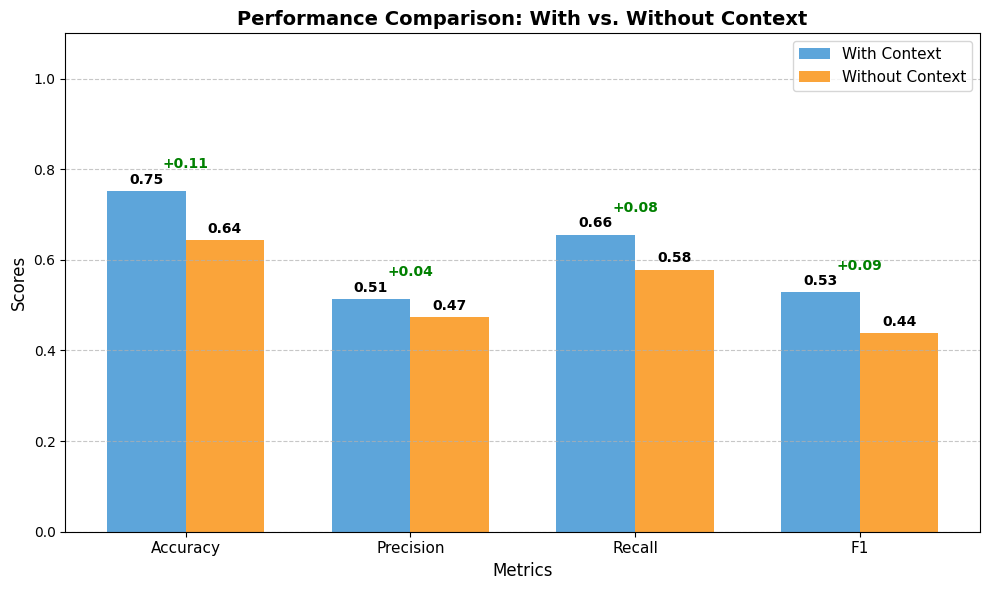

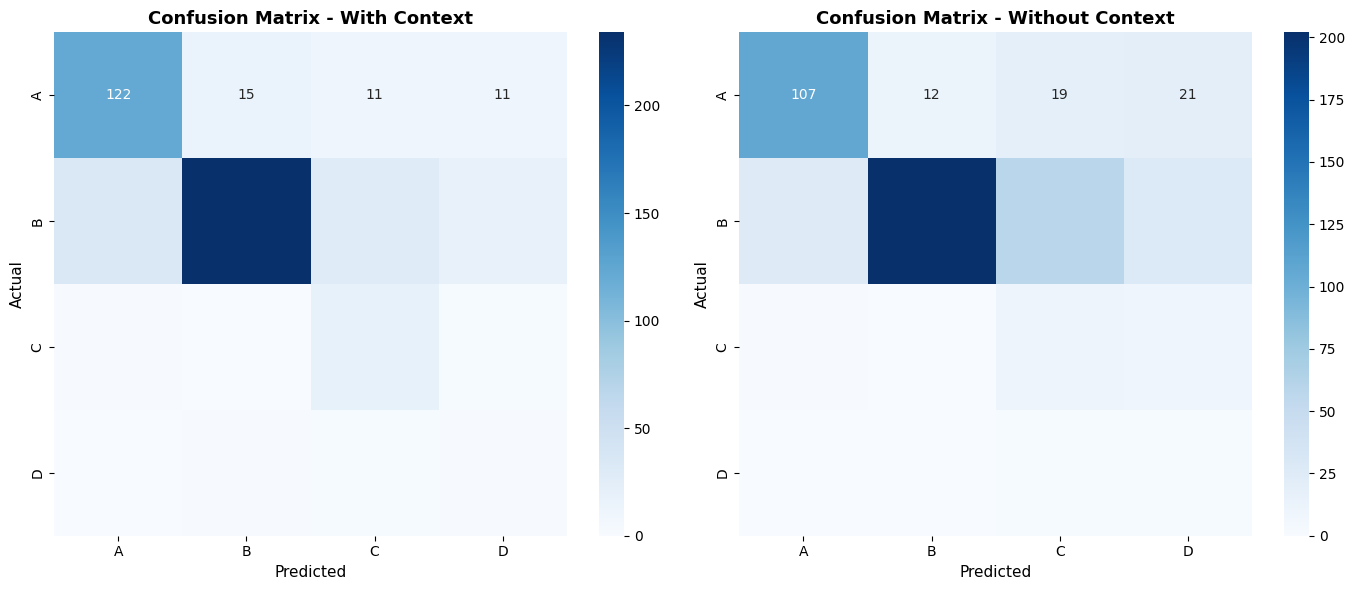

NameError: name 'Counter' is not defined

<Figure size 1000x600 with 0 Axes>

In [14]:
# Visualize metrics comparison
if with_context_metrics and without_context_metrics:
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    with_context_values = [with_context_metrics[m] for m in metrics]
    without_context_values = [without_context_metrics[m] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, with_context_values, width, label='With Context', color='#5DA5DA')
    rects2 = ax.bar(x + width/2, without_context_values, width, label='Without Context', color='#FAA43A')
    
    # Add labels and title
    ax.set_xlabel('Metrics', fontsize=12)
    ax.set_ylabel('Scores', fontsize=12)
    ax.set_title('Performance Comparison: With vs. Without Context', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([m.capitalize() for m in metrics], fontsize=11)
    ax.legend(fontsize=11)
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=10, fontweight='bold')
    
    add_labels(rects1)
    add_labels(rects2)
    
    # Add improvement percentages
    for i, metric in enumerate(metrics):
        improvement = with_context_values[i] - without_context_values[i]
        if improvement != 0:
            ax.annotate(f'{improvement:+.2f}',
                       xy=(i, max(with_context_values[i], without_context_values[i]) + 0.05),
                       ha='center',
                       color='green' if improvement > 0 else 'red',
                       fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Visualize confusion matrices for multi-class (MCQ)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Get labels from the confusion matrices
    labels = sorted(set(valid_refs + valid_preds))
    
    # With context confusion matrix
    sns.heatmap(with_context_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=labels, yticklabels=labels)
    ax1.set_title('Confusion Matrix - With Context', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Predicted', fontsize=11)
    ax1.set_ylabel('Actual', fontsize=11)
    
    # Without context confusion matrix
    sns.heatmap(without_context_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax2,
                xticklabels=labels, yticklabels=labels)
    ax2.set_title('Confusion Matrix - Without Context', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Predicted', fontsize=11)
    ax2.set_ylabel('Actual', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Add class distribution visualization
    plt.figure(figsize=(10, 6))
    class_counts = Counter(valid_refs)
    class_labels = sorted(class_counts.keys())
    class_values = [class_counts[label] for label in class_labels]
    
    plt.bar(class_labels, class_values, color='#60BD68')
    plt.title('Distribution of Answer Classes in Dataset', fontsize=14, fontweight='bold')
    plt.xlabel('Answer Option', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add count labels
    for i, v in enumerate(class_values):
        plt.text(i, v + 0.5, str(v), ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Add a per-class performance comparison
    # Extract per-class metrics from classification reports
    with_context_report = classification_report(valid_refs, valid_preds, labels=labels, output_dict=True)
    without_context_report = classification_report(valid_refs, valid_preds, labels=labels, output_dict=True)
    
    # Prepare data for plotting
    class_metrics = []
    for label in labels:
        if label in with_context_report and label in without_context_report:
            with_f1 = with_context_report[label]['f1-score']
            without_f1 = without_context_report[label]['f1-score']
            class_metrics.append({
                'class': label,
                'with_context': with_f1,
                'without_context': without_f1,
                'improvement': with_f1 - without_f1
            })
    
    if class_metrics:
        # Create DataFrame for easier plotting
        class_df = pd.DataFrame(class_metrics)
        
        # Plot per-class F1 scores
        plt.figure(figsize=(10, 6))
        
        x = np.arange(len(class_df))
        width = 0.35
        
        plt.bar(x - width/2, class_df['with_context'], width, label='With Context', color='#5DA5DA')
        plt.bar(x + width/2, class_df['without_context'], width, label='Without Context', color='#FAA43A')
        
        plt.xlabel('Answer Option', fontsize=12)
        plt.ylabel('F1 Score', fontsize=12)
        plt.title('F1 Score Comparison by Answer Option', fontsize=14, fontweight='bold')
        plt.xticks(x, class_df['class'])
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add improvement labels
        for i, row in enumerate(class_metrics):
            improvement = row['improvement']
            if improvement != 0:
                plt.annotate(f'{improvement:+.2f}',
                           xy=(i, max(row['with_context'], row['without_context']) + 0.05),
                           ha='center',
                           color='green' if improvement > 0 else 'red',
                           fontweight='bold')
        
        plt.tight_layout()
        plt.show()
else:
    print("Not enough data to visualize comparison")

In [ ]:
# Analyze the impact of context on each question
df['context_impact'] = None

for i, row in df.iterrows():
    # Get standardized answers for comparison
    ground_truth = row['standardized_answer']
    with_context = row['with_context_parsed']
    without_context = row['without_context_parsed']
    
    # Skip if ground truth or either prediction is None
    if ground_truth is None or with_context is None or without_context is None:
        df.at[i, 'context_impact'] = 'Unknown'
        continue
        
    with_correct = with_context == ground_truth
    without_correct = without_context == ground_truth
    
    if with_correct and not without_correct:
        df.at[i, 'context_impact'] = 'Positive'
    elif not with_correct and without_correct:
        df.at[i, 'context_impact'] = 'Negative'
    elif with_correct and without_correct:
        df.at[i, 'context_impact'] = 'Neutral'
    else:  # both incorrect
        df.at[i, 'context_impact'] = 'No Help'

# Summarize context impact
impact_counts = df['context_impact'].value_counts()
print("\nContext Impact Summary:")
for impact, count in impact_counts.items():
    percentage = count/len(df)*100
    print(f"{impact}: {count} questions ({percentage:.1f}%)")

# Calculate net positive impact
positive_count = impact_counts.get('Positive', 0)
negative_count = impact_counts.get('Negative', 0)
net_impact = positive_count - negative_count
net_percentage = net_impact / len(df) * 100
print(f"\nNet Positive Impact: {net_impact} questions ({net_percentage:.1f}%)")

# Visualize context impact with improved colors
plt.figure(figsize=(10, 6))
impact_order = ['Positive', 'Neutral', 'Negative', 'No Help', 'Unknown']
impact_colors = {
    'Positive': '#60BD68',  # Green
    'Neutral': '#5DA5DA',   # Blue
    'Negative': '#F15854',  # Red
    'No Help': '#FAA43A',   # Orange
    'Unknown': '#CCCCCC'    # Gray
}

# Reorder the data for consistent display
ordered_counts = []
ordered_labels = []
for impact in impact_order:
    if impact in impact_counts:
        ordered_counts.append(impact_counts[impact])
        ordered_labels.append(impact)

# Create the bar chart
bars = plt.bar(ordered_labels, ordered_counts, color=[impact_colors[impact] for impact in ordered_labels])
plt.title('Impact of Context on Multiple Choice Questions', fontsize=14, fontweight='bold')
plt.xlabel('Impact Type', fontsize=12)
plt.ylabel('Number of Questions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count and percentage labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = height/len(df)*100
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(height)}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Additional analysis: When does context help vs. hurt?
# Create a function to extract key features from questions
def extract_features(question):
    features = {}
    # Check for question types
    features['is_cause_effect'] = 'cause' in question.lower() or 'because' in question.lower() or 'due to' in question.lower()
    features['mentions_specific_condition'] = any(word in question.lower() for word in ['diabetes', 'hypertension', 'obesity', 'smoking'])
    features['mentions_therapy'] = any(word in question.lower() for word in ['therapy', 'treatment', 'surgery', 'injection'])
    features['about_disease_mechanism'] = 'mechanism' in question.lower() or 'pathway' in question.lower()
    return features

# Apply feature extraction
for i, row in df.iterrows():
    features = extract_features(row['question'])
    for feature, value in features.items():
        df.at[i, feature] = value

# Analyze which features correlate with positive context impact
print("\nFeature Analysis for Context Impact:")
features = ['is_cause_effect', 'mentions_specific_condition', 'mentions_therapy', 'about_disease_mechanism']

for feature in features:
    positive_with_feature = df[(df['context_impact'] == 'Positive') & (df[feature] == True)].shape[0]
    total_with_feature = df[df[feature] == True].shape[0]
    
    negative_with_feature = df[(df['context_impact'] == 'Negative') & (df[feature] == True)].shape[0]
    
    if total_with_feature > 0:
        positive_rate = positive_with_feature / total_with_feature * 100
        negative_rate = negative_with_feature / total_with_feature * 100
        print(f"\nFeature: {feature}")
        print(f"  Questions with this feature: {total_with_feature}")
        print(f"  Positive impact rate: {positive_rate:.1f}%")
        print(f"  Negative impact rate: {negative_rate:.1f}%")
        print(f"  Net positive rate: {positive_rate - negative_rate:.1f}%")

# Visualize the feature analysis
feature_data = []
for feature in features:
    positive_count = df[(df['context_impact'] == 'Positive') & (df[feature] == True)].shape[0]
    negative_count = df[(df['context_impact'] == 'Negative') & (df[feature] == True)].shape[0]
    total_count = df[df[feature] == True].shape[0]
    
    if total_count > 0:
        feature_data.append({
            'feature': feature.replace('_', ' ').title(),
            'positive_rate': positive_count / total_count * 100,
            'negative_rate': negative_count / total_count * 100,
            'neutral_rate': (total_count - positive_count - negative_count) / total_count * 100
        })

if feature_data:
    feature_df = pd.DataFrame(feature_data)
    
    # Plot the feature analysis
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(feature_df))
    width = 0.25
    
    plt.bar(x - width, feature_df['positive_rate'], width, label='Positive Impact', color='#60BD68')
    plt.bar(x, feature_df['negative_rate'], width, label='Negative Impact', color='#F15854')
    plt.bar(x + width, feature_df['neutral_rate'], width, label='Neutral/No Help', color='#5DA5DA')
    
    plt.xlabel('Question Features', fontsize=12)
    plt.ylabel('Percentage of Questions', fontsize=12)
    plt.title('Impact of Context by Question Feature', fontsize=14, fontweight='bold')
    plt.xticks(x, feature_df['feature'])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Generate a summary report
print("\n" + "=" * 80)
print("EVALUATION SUMMARY REPORT - MULTIPLE CHOICE QUESTIONS")
print("=" * 80)

# Count valid questions and answers
valid_questions = df['standardized_answer'].notna().sum()
total_questions = len(df)

print(f"Total Questions: {total_questions}")
print(f"Questions with Valid Ground Truth: {valid_questions} ({valid_questions/total_questions*100:.1f}%)")

# Count distribution of answers
if valid_questions > 0:
    answer_counts = df['standardized_answer'].value_counts()
    print("\nDistribution of Ground Truth Answers:")
    for answer, count in answer_counts.items():
        print(f"  Option {answer}: {count} questions ({count/valid_questions*100:.1f}%)")

# Performance metrics
print("\nPerformance Summary:")
if with_context_metrics and without_context_metrics:
    print(f"With Context Accuracy: {with_context_metrics['accuracy']:.2f} ({with_context_metrics['accuracy']*100:.1f}%)")
    print(f"Without Context Accuracy: {without_context_metrics['accuracy']:.2f} ({without_context_metrics['accuracy']*100:.1f}%)")
    print(f"With Context Macro F1: {with_context_metrics['f1']:.2f}")
    print(f"Without Context Macro F1: {without_context_metrics['f1']:.2f}")
    
    # Determine if context helped overall
    if with_context_metrics['accuracy'] > without_context_metrics['accuracy']:
        diff = with_context_metrics['accuracy'] - without_context_metrics['accuracy']
        rel_improvement = diff / without_context_metrics['accuracy'] * 100
        print(f"\nContext improved accuracy by {diff:.2f} ({diff*100:.1f}% absolute, {rel_improvement:.1f}% relative)")
    elif with_context_metrics['accuracy'] < without_context_metrics['accuracy']:
        diff = without_context_metrics['accuracy'] - with_context_metrics['accuracy']
        rel_decline = diff / with_context_metrics['accuracy'] * 100
        print(f"\nContext decreased accuracy by {diff:.2f} ({diff*100:.1f}% absolute, {rel_decline:.1f}% relative)")
    else:
        print("\nContext had no overall impact on accuracy")

# Context impact summary
print("\nContext Impact Analysis:")
for impact, count in impact_counts.items():
    print(f"  {impact}: {count} questions ({count/total_questions*100:.1f}%)")

# Calculate net positive ratio
positive_count = impact_counts.get('Positive', 0)
negative_count = impact_counts.get('Negative', 0)
if positive_count + negative_count > 0:
    positive_ratio = positive_count / (positive_count + negative_count)
    print(f"\nPositive-to-Negative Impact Ratio: {positive_ratio:.2f} ({positive_count}:{negative_count})")

# Per-option performance
print("\nPer-Option Performance (With Context):")
# Create a dictionary to store per-option accuracy
option_metrics = {}

# Identify options present in the dataset
all_options = set(df['standardized_answer'].dropna())

# Calculate metrics for each option
for option in all_options:
    option_indices = df[df['standardized_answer'] == option].index
    correct_count = sum(1 for i in option_indices if df.loc[i, 'with_context_parsed'] == option)
    total_count = len(option_indices)
    if total_count > 0:
        accuracy = correct_count / total_count
        option_metrics[option] = {
            'accuracy': accuracy,
            'count': total_count,
            'correct': correct_count
        }

# Display per-option metrics
for option in sorted(option_metrics.keys()):
    metrics = option_metrics[option]
    print(f"  Option {option}: {metrics['accuracy']:.2f} accuracy ({metrics['correct']}/{metrics['count']} correct)")

# List top 5 questions where context helped (max 5)
helped_questions = df[df['context_impact'] == 'Positive'].head(5)
if not helped_questions.empty:
    print("\nSample Questions Where Context Helped:")
    for i, row in helped_questions.iterrows():
        print(f"- Q{i}: {row['question']}")
        print(f"  Ground Truth: {row['standardized_answer']}")
        print(f"  With Context: {row['with_context_parsed']} | Without Context: {row['without_context_parsed']}")

# List top 5 questions where context was misleading (max 5)
misled_questions = df[df['context_impact'] == 'Negative'].head(5)
if not misled_questions.empty:
    print("\nSample Questions Where Context Was Misleading:")
    for i, row in misled_questions.iterrows():
        print(f"- Q{i}: {row['question']}")
        print(f"  Ground Truth: {row['standardized_answer']}")
        print(f"  With Context: {row['with_context_parsed']} | Without Context: {row['without_context_parsed']}")

# Conclusions
print("\nConclusions:")
print("1. Context retrieval" + 
      (" improved " if with_context_metrics.get('accuracy', 0) > without_context_metrics.get('accuracy', 0) else " did not improve ") + 
      "overall accuracy for multiple choice questions.")

print(f"2. {impact_counts.get('Positive', 0)} questions benefited from context, while {impact_counts.get('Negative', 0)} questions were negatively affected.")

# Per-option performance insights
best_option = max(option_metrics.items(), key=lambda x: x[1]['accuracy'])[0] if option_metrics else None
worst_option = min(option_metrics.items(), key=lambda x: x[1]['accuracy'])[0] if option_metrics else None

if best_option and worst_option:
    print(f"3. Performance varied by answer option: Option {best_option} had the highest accuracy, while Option {worst_option} had the lowest.")

# Recommendations
print("\nRecommendations:")
if with_context_metrics.get('accuracy', 0) > without_context_metrics.get('accuracy', 0):
    print("1. Continue using RAG for multiple choice questions, with focus on improving quality of retrieved contexts.")
    print("2. Consider a hybrid approach that evaluates context quality before deciding whether to use it.")
    print(f"3. Pay special attention to questions where option {worst_option} is the correct answer, as these showed lower accuracy.")
else:
    print("1. Review and improve context retrieval quality for multiple choice questions.")
    print("2. Consider limiting RAG to specific types of questions where context has shown to be helpful.")
    print("3. For questions with poor context performance, consider reverting to model-only answers.")

print("4. Expand the evaluation dataset to include more diverse multiple choice question types.")
print("5. Further analyze questions where context was misleading to identify patterns and potential improvements.")